In [1]:
# Half-QAE (Quantum Autoencoder) Replication Notebook
# ==================================================
# Stage 1: Train ENCODER on clean data so that Encoder(phi) + Encoder(phi)† reconstruct the input (2→4 via adjoint)

def read_ts_file(filepath: str): 
    """Placeholder for IDE - actual function imported from qae_utils.Files"""
    pass

def read_json_file(filepath: str): 
    """Placeholder for IDE - actual function imported from qae_utils.Files"""
    pass

print("Notebook initialized - ready to import dependencies")


Notebook initialized - ready to import dependencies


In [2]:
import os, sys, json, math, random
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Resolve repo paths
current_dir = os.path.dirname(os.path.abspath(''))
parent_dir = os.path.dirname(current_dir) if os.path.basename(current_dir) == 'Jacob' else current_dir
sys.path.insert(0, parent_dir)
sys.path.insert(0, '../')

# Robust import of utils
try:
    from qae_utils.Files import read_ts_file, read_json_file
    print("Imports successful!")
except Exception as e:
    print("Import error:", e)
    qae_utils_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(''))), 'qae_utils')
    sys.path.insert(0, os.path.dirname(qae_utils_path))
    from qae_utils.Files import read_ts_file, read_json_file
    print("Absolute path fallback successful!")

# Quick sanity
assert callable(read_ts_file) and callable(read_json_file)
print("Function availability confirmed")

# Reproducibility
np.random.seed(1007)
random.seed(1007)


Imports successful!
Function availability confirmed


In [3]:
DATA_PATH = '../jacobs_examples/aintern/data'
DATA_NAME = 'mackey_glass'

try:
    data_folders = [f for f in os.listdir(DATA_PATH) if f.startswith(DATA_NAME)]
    if not data_folders:
        raise FileNotFoundError("No Mackey-Glass data found. Please run the data generation notebook first.")

    data_folder = data_folders[0]
    print(f"Using data from: {data_folder}")
    print(f"Full data path: {DATA_PATH}/{data_folder}")

    X = read_ts_file(f'{DATA_PATH}/{data_folder}/x_org.arr')   # indices for plotting; not used in training
    y = read_ts_file(f'{DATA_PATH}/{data_folder}/y_org.arr')   # time-series values
    info = read_json_file(f'{DATA_PATH}/{data_folder}/info.json')

    print(f"Loaded {len(y)} samples")
    print(f"Data range: [{np.min(y):.3f}, {np.max(y):.3f}]")
    print(f"Scale info: low={info['scale_low']}, high={info['scale_high']}")
except Exception as e:
    print(f"Error loading data: {e}")
    print(f"CWD: {os.getcwd()}")
    print(f"Looked in: {os.path.abspath(DATA_PATH)}")
    raise


Using data from: mackey_glass_n100
Full data path: ../jacobs_examples/aintern/data/mackey_glass_n100
Loaded 100 samples
Data range: [0.230, 0.789]
Scale info: low=0.2, high=0.8


In [4]:
# QAE sizes
n_qubits = 4
n_latent = 2
n_trash  = n_qubits - n_latent
signal_wires = list(range(n_qubits))  # Stage 1: reconstruct ALL 4 outputs

# Circuit depth
n_layers = 3

# Quantum device
dev = qml.device('default.qubit', wires=n_qubits)
print(f"Device ready: {n_qubits} wires")

# Helper: scaling back expvals [-1,1] -> original data range
def scale_back(expvals):
    lo, hi = info['scale_low'], info['scale_high']
    return (expvals + 1.0)/2.0 * (hi - lo) + lo


Device ready: 4 wires


In [5]:
def embed_input(x):
    """Map real-valued window x (in [lo,hi]) to angles via normalized RY."""
    lo, hi = info['scale_low'], info['scale_high']
    xn = (pnp.array(x) - lo) / max(hi - lo, 1e-12)   # -> [0,1]
    for i, v in enumerate(xn[:n_qubits]):
        qml.RY(v * pnp.pi, wires=i)

def encoder_template(params):
    """Parameterized encoder on ALL 4 wires; compression emerges via adjoint training."""
    assert len(params) == n_layers * n_qubits * 3
    for l in range(n_layers):
        # Local rotations
        for q in range(n_qubits):
            idx = l * n_qubits * 3 + q * 3
            qml.RX(params[idx + 0], wires=q)
            qml.RY(params[idx + 1], wires=q)
            qml.RZ(params[idx + 2], wires=q)
        # Light entanglement (ring)
        for q in range(n_qubits-1):
            qml.CNOT(wires=[q, q+1])
        qml.CNOT(wires=[n_qubits-1, 0])


In [6]:
trash_wires = [2, 3]  # keep as in your setup

@qml.qnode(dev, interface="autograd", diff_method="backprop")
def stage1_trash_expectations(phi, x_clean):
    """
    Apply encoder E(phi) to the clean window and return ⟨Z⟩ on trash wires.
    From these we compute P(|1>) = (1 - ⟨Z⟩)/2 as a compression loss.
    """
    embed_input(x_clean)
    encoder_template(phi)  # NO adjoint here in Stage 1
    return [qml.expval(qml.PauliZ(w)) for w in trash_wires]


In [7]:
window_size = n_qubits
stride = 1
print(f"Creating sliding windows: size={window_size}, stride={stride}")

X_windows = []
for i in range(0, len(y) - window_size + 1, stride):
    X_windows.append(y[i:i+window_size])
X_windows = np.array(X_windows)
print(f"Total windows: {len(X_windows)}")

X_temp, X_test = train_test_split(X_windows, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_temp, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2
print(f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")


Creating sliding windows: size=4, stride=1
Total windows: 97
Train=57, Val=20, Test=20


In [8]:
def stage1_batch_loss(phi, clean_batch):
    """
    Compression objective:
      L = mean_over_batch_and_trash_wires  P_trash(|1>)
        = mean( (1 - ⟨Z⟩)/2 )
    This encourages the encoder to map the training manifold into
    a code subspace where trash ≈ |0⟩.
    """
    zs = []
    for c in clean_batch:
        z = pnp.array(stage1_trash_expectations(phi, c))  # shape (n_trash,)
        zs.append(z)
    zs = pnp.stack(zs, axis=0)             # (B, n_trash)
    prob_one = (1.0 - zs) * 0.5            # (B, n_trash)
    return pnp.mean(prob_one)              # scalar


In [9]:
# Stage 1 training loop (WITH history + simple LR scheduler)

enc_shape = n_layers * n_qubits * 3
phi = pnp.array(np.random.normal(0, 0.5, enc_shape), requires_grad=True)

# Training hyperparams
n_epochs    = 120
batch_size  = 32
lr = 0.010                      # start LR
opt = qml.AdamOptimizer(stepsize=lr)
patience      = 10              # early stop patience
lr_patience   = 8               # epochs of no improvement before halving LR
min_delta     = 1e-6

def minibatches(X, B):
    idx = np.random.permutation(len(X))
    for i in range(0, len(X), B):
        yield idx[i:i+B]

stage1_train_hist, stage1_val_hist, stage1_lr_hist = [], [], []
best_phi = None
best_val = float("inf")
no_improve = 0

for ep in range(n_epochs):  # allow more epochs; early stop + scheduler will cap it
    # --- training ---
    train_cost = 0.0; batches = 0
    for idx in minibatches(X_train, batch_size):
        clean_batch = X_train[idx]
        def loss_fn(p): return stage1_batch_loss(p, clean_batch)
        phi, cost = opt.step_and_cost(loss_fn, phi)
        train_cost += cost; batches += 1
    train_cost /= max(batches, 1)

    # --- validation on compression objective ---
    v_costs = []
    for c in X_val:
        v_costs.append(stage1_batch_loss(phi, pnp.array([c])))
    val_cost = float(pnp.mean(pnp.stack(v_costs)))

    stage1_train_hist.append(float(train_cost))
    stage1_val_hist.append(float(val_cost))
    stage1_lr_hist.append(lr)

    # --- early stopping + LR schedule ---
    if val_cost + min_delta < best_val:
        best_val = val_cost; best_phi = phi; no_improve = 0
    else:
        no_improve += 1
        # halve LR if plateauing
        if no_improve % lr_patience == 0:
            lr = max(lr * 0.5, 1e-4)
            opt = qml.AdamOptimizer(stepsize=lr)
            print(f"[Stage1] ↓ LR to {lr:.5f}")
        # stop if too long without improvement
        if no_improve >= patience:
            print("Early stopping."); break

    print(f"[Stage1] Ep {ep:03d} | train {train_cost:.6f} | val {val_cost:.6f} | LR {lr:.5f}")

phi_stage1 = best_phi if best_phi is not None else phi
print("Stage 1 complete. Best compression (mean P_trash(|1>)):", best_val)


[Stage1] Ep 000 | train 0.511439 | val 0.503317 | LR 0.01000
[Stage1] Ep 001 | train 0.491464 | val 0.482525 | LR 0.01000
[Stage1] Ep 002 | train 0.470844 | val 0.462069 | LR 0.01000
[Stage1] Ep 003 | train 0.451198 | val 0.441996 | LR 0.01000
[Stage1] Ep 004 | train 0.430630 | val 0.422498 | LR 0.01000
[Stage1] Ep 005 | train 0.412443 | val 0.403836 | LR 0.01000
[Stage1] Ep 006 | train 0.393775 | val 0.386395 | LR 0.01000
[Stage1] Ep 007 | train 0.375243 | val 0.370568 | LR 0.01000
[Stage1] Ep 008 | train 0.362661 | val 0.356145 | LR 0.01000
[Stage1] Ep 009 | train 0.348610 | val 0.343297 | LR 0.01000
[Stage1] Ep 010 | train 0.339823 | val 0.331954 | LR 0.01000
[Stage1] Ep 011 | train 0.330625 | val 0.322010 | LR 0.01000
[Stage1] Ep 012 | train 0.322624 | val 0.313141 | LR 0.01000
[Stage1] Ep 013 | train 0.312838 | val 0.305221 | LR 0.01000
[Stage1] Ep 014 | train 0.307344 | val 0.298023 | LR 0.01000
[Stage1] Ep 015 | train 0.301786 | val 0.291379 | LR 0.01000
[Stage1] Ep 016 | train 

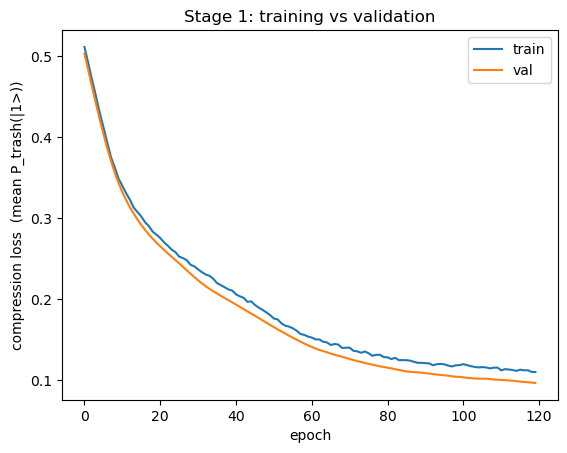

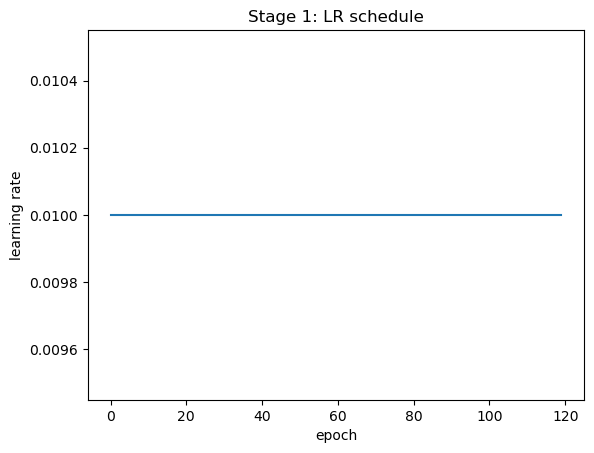

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(stage1_train_hist, label="train")
plt.plot(stage1_val_hist, label="val")
plt.xlabel("epoch"); plt.ylabel("compression loss  (mean P_trash(|1>))")
plt.title("Stage 1: training vs validation")
plt.legend(); plt.show()

plt.figure()
plt.plot(stage1_lr_hist)
plt.xlabel("epoch"); plt.ylabel("learning rate")
plt.title("Stage 1: LR schedule")
plt.show()


In [12]:
# -- QNodes for analysis --

# 1) Probability distribution on trash wires AFTER the encoder
@qml.qnode(dev, interface="autograd", diff_method="backprop")
def trash_probs_after_encoder(phi, x_clean):
    embed_input(x_clean)
    encoder_template(phi)
    return qml.probs(wires=trash_wires)   # order: |00>, |01>, |10>, |11>

# 2) Per-wire expvals on ALL wires after encoder (to inspect P(|1>)=(1-Z)/2)
@qml.qnode(dev, interface="autograd", diff_method="backprop")
def expvals_after_encoder(phi, x_clean):
    embed_input(x_clean)
    encoder_template(phi)
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

# 3) Reconstruction via E†E on clean data (identity check)
@qml.qnode(dev, interface="autograd", diff_method="backprop")
def recon_EdagE(phi, x_clean):
    embed_input(x_clean)
    encoder_template(phi)
    qml.adjoint(encoder_template)(phi)
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]


In [13]:
import numpy as _np
from statistics import median

def compute_stage1_metrics(phi, X_eval):
    P00_list, P01_list, P10_list, P11_list = [], [], [], []
    p1_trash_w2, p1_trash_w3 = [], []
    recon_mse_list = []

    for c in X_eval:
        # Trash distribution after encoder
        p_tr = _np.array(trash_probs_after_encoder(phi, c))
        P00_list.append(p_tr[0]); P01_list.append(p_tr[1])
        P10_list.append(p_tr[2]); P11_list.append(p_tr[3])

        # Per-wire P(|1>) on trash (from Z expvals)
        z_all = _np.array(expvals_after_encoder(phi, c))   # wires 0..3
        p1 = (1.0 - z_all) / 2.0
        p1_trash_w2.append(p1[2]); p1_trash_w3.append(p1[3])

        # E†E reconstruction MSE on all 4 outputs
        y_hat = _np.array(recon_EdagE(phi, c))
        y_hat = _np.array(scale_back(y_hat))
        recon_mse_list.append(_np.mean((_np.array(c) - y_hat)**2))

    P00 = _np.array(P00_list)
    P11 = _np.array(P11_list)
    P01 = _np.array(P01_list)
    P10 = _np.array(P10_list)
    p1_w2 = _np.array(p1_trash_w2)
    p1_w3 = _np.array(p1_trash_w3)
    mse  = _np.array(recon_mse_list)

    out = {
        "P00_mean": float(P00.mean()), "P00_median": float(_np.median(P00)),
        "P00_p10": float(_np.percentile(P00,10)), "P00_p90": float(_np.percentile(P00,90)),
        "P11_mean": float(P11.mean()),
        "p1_w2_mean": float(p1_w2.mean()), "p1_w3_mean": float(p1_w3.mean()),
        "recon_mse_mean": float(mse.mean()), "recon_mse_median": float(_np.median(mse)),
        "corr_P00_vs_MSE": float(_np.corrcoef(P00, mse)[0,1]) if len(P00)>1 else _np.nan,
        "P00_all": P00, "MSE_all": mse, "p1_w2_all": p1_w2, "p1_w3_all": p1_w3,
        "P01_all": P01, "P10_all": P10, "P11_all": P11
    }
    return out

metrics_val = compute_stage1_metrics(phi_stage1, X_val)
print({
    k:v for k,v in metrics_val.items() if isinstance(v, (int,float))
})


{'P00_mean': 0.843192045431268, 'P00_median': 0.840980865239687, 'P00_p10': 0.7338209317561161, 'P00_p90': 0.9340137637313727, 'P11_mean': 0.03560414910970529, 'p1_w2_mean': 0.08874632760310192, 'p1_w3_mean': 0.10366577607533545, 'recon_mse_mean': 0.09663591508289139, 'recon_mse_median': 0.08266091919540272, 'corr_P00_vs_MSE': -0.48377595127708567}


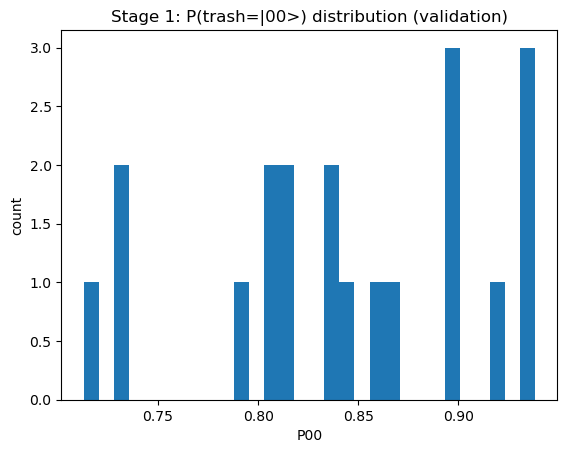

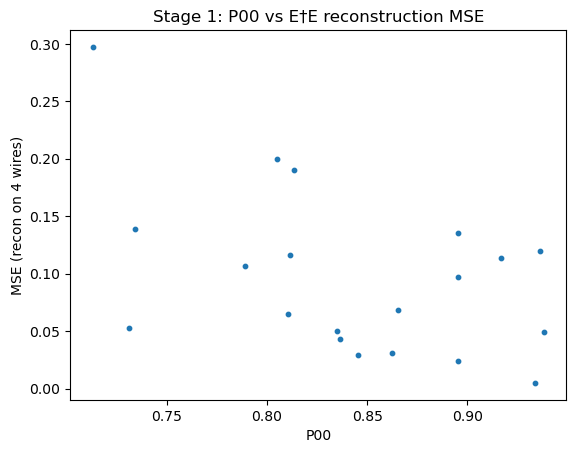

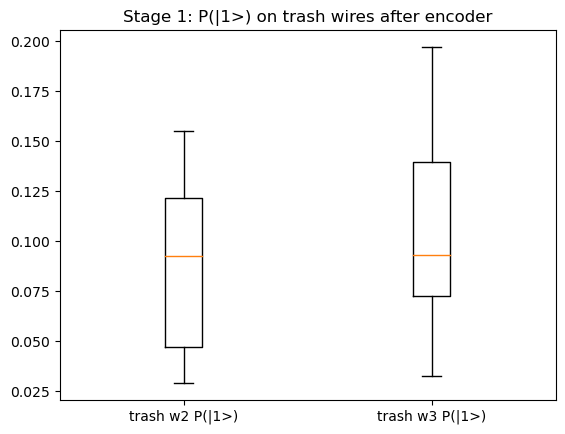

In [14]:
import matplotlib.pyplot as plt

P00 = metrics_val["P00_all"]
MSE = metrics_val["MSE_all"]
p1_w2 = metrics_val["p1_w2_all"]
p1_w3 = metrics_val["p1_w3_all"]

plt.figure()
plt.hist(P00, bins=30)
plt.title("Stage 1: P(trash=|00>) distribution (validation)")
plt.xlabel("P00"); plt.ylabel("count")
plt.show()

plt.figure()
plt.scatter(P00, MSE, s=10)
plt.title("Stage 1: P00 vs E†E reconstruction MSE")
plt.xlabel("P00"); plt.ylabel("MSE (recon on 4 wires)")
plt.show()

plt.figure()
plt.boxplot([p1_w2, p1_w3], labels=["trash w2 P(|1>)","trash w3 P(|1>)"])
plt.title("Stage 1: P(|1>) on trash wires after encoder")
plt.show()


Selected indices: {'best': array([5]), 'median': array([10]), 'worst': array([3])}  (showing one for each)


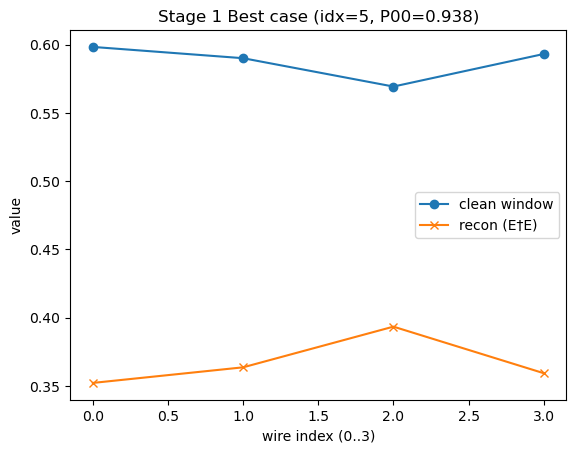

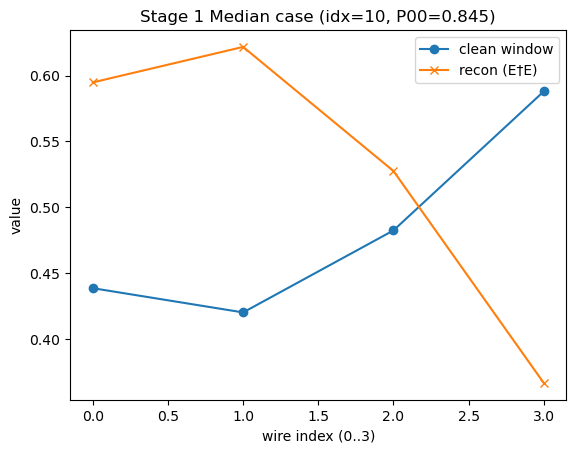

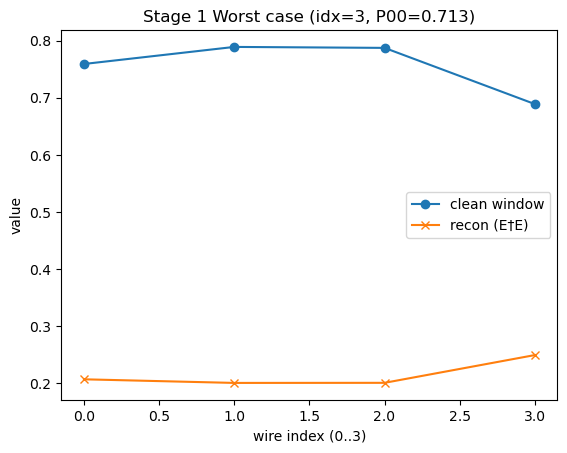

In [15]:
import numpy as _np

def pick_indices_by_P00(phi, X_eval, k=1):
    P00s = []
    for c in X_eval:
        P00s.append(_np.array(trash_probs_after_encoder(phi, c))[0])
    P00s = _np.array(P00s)
    order = _np.argsort(P00s)  # low→high
    return {
        "best": order[-k:][::-1],   # highest P00
        "median": order[[len(order)//2]],
        "worst": order[:k]          # lowest P00
    }, P00s

def recon_series(phi, x_window):
    y_hat = _np.array(recon_EdagE(phi, x_window))
    return _np.array(scale_back(y_hat))

# pick
sel, P00_all = pick_indices_by_P00(phi_stage1, X_val, k=1)
print("Selected indices:", sel, " (showing one for each)")

def plot_case(idx, title):
    c = X_val[idx]
    r = recon_series(phi_stage1, c)
    plt.figure()
    plt.plot(c, marker='o', label='clean window')
    plt.plot(r, marker='x', label='recon (E†E)')
    plt.title(f"{title} (idx={idx}, P00={float(trash_probs_after_encoder(phi_stage1, c)[0]):.3f})")
    plt.xlabel("wire index (0..3)"); plt.ylabel("value")
    plt.legend(); plt.show()

for tag in ["best","median","worst"]:
    plot_case(int(sel[tag][0]), f"Stage 1 {tag.capitalize()} case")


In [16]:
# After encoder: compare latent vs trash P(|1>) histograms (expect trash lower)
@qml.qnode(dev, interface="autograd", diff_method="backprop")
def z_all_after_encoder(phi, x_clean):
    embed_input(x_clean); encoder_template(phi)
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

p1_latent_0, p1_latent_1, p1_trash_2, p1_trash_3 = [], [], [], []
for c in X_val:
    z = _np.array(z_all_after_encoder(phi_stage1, c))
    p1 = (1-z)/2
    p1_latent_0.append(p1[0]); p1_latent_1.append(p1[1])
    p1_trash_2.append(p1[2]);  p1_trash_3.append(p1[3])

def _m(a): return float(_np.mean(a))
print({
    "P(|1>) latent0 mean": _m(p1_latent_0),
    "P(|1>) latent1 mean": _m(p1_latent_1),
    "P(|1>) trash2 mean": _m(p1_trash_2),
    "P(|1>) trash3 mean": _m(p1_trash_3),
})


{'P(|1>) latent0 mean': 0.5117048316809837, 'P(|1>) latent1 mean': 0.4591317613677145, 'P(|1>) trash2 mean': 0.08874632760310192, 'P(|1>) trash3 mean': 0.10366577607533545}


In [17]:
# Identity check in the *observable* domain: ⟨Z⟩(embed) ≈ ⟨Z⟩(E†E after embed)
@qml.qnode(dev, interface="autograd", diff_method="backprop")
def z_after_embed(x_clean):
    embed_input(x_clean)
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

def identity_observable_mse(phi, X_eval):
    errs = []
    for c in X_eval:
        z0 = np.array(z_after_embed(c))
        z1 = np.array(recon_EdagE(phi, c))  # from previous T1 cell
        errs.append(np.mean((z0 - z1)**2))
    return float(np.mean(errs))

print("E†E observable MSE vs embed-only:",
      identity_observable_mse(phi_stage1, X_val))


E†E observable MSE vs embed-only: 2.780657653706291e-31


In [18]:
# Save the clean encoder learned in Stage 1 (phi_stage1)
save_dir = f"{DATA_PATH}/{data_folder}"
os.makedirs(save_dir, exist_ok=True)

stage1_summary = {
    "encoder_stage1_params": list(map(float, np.array(phi_stage1))),
    "n_qubits": n_qubits,
    "n_latent": n_latent,
    "n_layers": n_layers,
    "trash_wires": [2,3],
    "signal_wires": list(range(n_qubits)),   # full window used in Stage 1 diagnostics
    "train_history": stage1_train_hist,
    "val_history": stage1_val_hist,
    "lr_history": stage1_lr_hist,
    "data_name": DATA_NAME,
}

out_path = os.path.join(save_dir, "encoder_stage1_clean.json")
with open(out_path, "w") as f:
    json.dump(stage1_summary, f, indent=2)
print("Saved Stage-1 encoder to:", out_path)


Saved Stage-1 encoder to: ../jacobs_examples/aintern/data/mackey_glass_n100/encoder_stage1_clean.json


In [494]:
# ================================
# Cell S3-1: load Stage-1 summary
# ================================
# === Robust loaders for Stage-1 and optional Stage-3 ===
import os, json
from pathlib import Path
import numpy as np
import pennylane.numpy as pnp

def _try_load_json(candidates):
    """Return (data, path) for the first existing JSON in candidates; (None, None) if none."""
    for p in candidates:
        p = Path(p)
        if p.exists():
            with open(p, "r") as f:
                return json.load(f), str(p)
    return None, None

def _list_jsons(dirpath):
    try:
        return [p.name for p in Path(dirpath).glob("*.json")]
    except Exception:
        return []

def load_stage1_summary(preferred_path=None):
    """
    Load Stage-1 summary JSON. Tries:
      1) preferred_path (if provided)
      2) canonical path (mackey_glass_n100/encoder_stage1_clean.json)
      3) DATA_PATH/data_folder with several filename patterns (incl. your old 'half_qae' style)
    """
    candidates = []
    if preferred_path:
        candidates.append(preferred_path)

    # Canonical path you gave earlier
    candidates.append("/jacobs_examples/aintern/data/mackey_glass_n100/encoder_stage1_clean.json")

    # If you still have DATA_PATH/data_folder defined, search there too
    if "DATA_PATH" in globals() and "data_folder" in globals():
        dd = Path(DATA_PATH) / data_folder
        if dd.exists():
            patterns = [
                "encoder_stage1_clean.json",
                "encoder_stage1*.json",
                "*stage1*clean*.json",
            ]
            for pat in patterns:
                candidates.extend([str(p) for p in dd.glob(pat)])

    data, path = _try_load_json(candidates)
    if data is None:
        # Helpful error: list what JSONs are actually available in those dirs
        dirs_tried = sorted(set([str(Path(c).parent) for c in candidates]))
        available = []
        for d in dirs_tried:
            available += [f"{d}/{n}" for n in _list_jsons(d)]
        tried_msg = "\n  ".join(sorted(set(candidates))) if candidates else "(no candidates)"
        avail_msg = "\n  ".join(available) if available else "(no JSON files found in candidate dirs)"
        raise FileNotFoundError(
            "Could not find a Stage-1 summary JSON.\n"
            f"Tried:\n  {tried_msg}\n\nAvailable JSONs:\n  {avail_msg}"
        )

    # Validate shape and required fields
    required = ["encoder_stage1_params", "n_qubits", "n_latent", "n_layers", "trash_wires"]
    missing = [k for k in required if k not in data]
    if missing:
        raise ValueError(f"Stage-1 file missing keys: {missing} (path={path})")

    # Convert params and check length: we used RX, RY, RZ per layer/qubit => length = L * Q * 3
    n_qubits  = int(data["n_qubits"])
    n_layers  = int(data["n_layers"])
    n_latent  = int(data["n_latent"])
    expected  = n_layers * n_qubits * 3
    phi_stage1 = pnp.array(data["encoder_stage1_params"], requires_grad=False)
    if int(phi_stage1.size) != expected:
        raise ValueError(
            f"encoder_stage1_params length {phi_stage1.size} != expected {expected} (= n_layers*n_qubits*3). "
            f"(path={path})"
        )

    print(f"Loaded Stage-1 from: {path}")
    print(f"n_qubits={n_qubits}, n_layers={n_layers}, n_latent={n_latent}, trash_wires={list(data['trash_wires'])}")
    return data, path, phi_stage1

# --- Use the loaders ---
stage1_summary, s1_path, phi_stage1 = load_stage1_summary(
    preferred_path="/jacobs_examples/aintern/data/mackey_glass_n100/encoder_stage1_clean.json"
)

# Pull key metadata from the file (avoid accidental mismatch with globals)
n_qubits = int(stage1_summary["n_qubits"])
n_layers = int(stage1_summary["n_layers"])
n_latent = int(stage1_summary["n_latent"])
trash_wires = list(stage1_summary["trash_wires"])
signal_wires = list(stage1_summary.get("signal_wires", list(range(n_qubits))))  # Stage-1 used all 4 for diagnostics



Loaded Stage-1 from: ../jacobs_examples/aintern/data/mackey_glass_n100/encoder_stage1_clean.json
n_qubits=4, n_layers=3, n_latent=2, trash_wires=[2, 3]


In [495]:
# ================================
# Cell S3-2 (clean): QNodes for Stage-3
# ================================
import pennylane as qml
import pennylane.numpy as pnp
import numpy as np

LATENT_WIRES  = list(range(n_latent))               # [0,1]
TRASH_WIRES   = list(range(n_latent, n_qubits))     # [2,3]
STAGE3_SIGNAL_WIRES = LATENT_WIRES

print("Stage-3 -> latents:", LATENT_WIRES, "trash:", TRASH_WIRES)

# --- Fixed decoder parameters = reshape Stage-1 encoder params ---
theta_fixed = pnp.array(phi_stage1, requires_grad=False).reshape((n_layers, n_qubits, 3))

# --- circuit bricks matching your Stage-1 encoder ---
def encoder_fixed_body(theta):
    """Non-trainable copy of your encoder (for building D = E(φ)† and the teacher)."""
    for l in range(n_layers):
        for q in range(n_qubits):
            qml.RX(theta[l, q, 0], wires=q)
            qml.RY(theta[l, q, 1], wires=q)
            qml.RZ(theta[l, q, 2], wires=q)
        for q in range(n_qubits - 1):
            qml.CNOT(wires=[q, q + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

def decoder_fixed():
    """Apply the adjoint of the fixed encoder."""
    qml.adjoint(encoder_fixed_body)(theta_fixed)

def encoder_template(flat_params):
    """Trainable student encoder (same pattern as Stage-1)."""
    assert len(flat_params) == n_layers * n_qubits * 3
    for l in range(n_layers):
        for q in range(n_qubits):
            idx = l * n_qubits * 3 + q * 3
            qml.RX(flat_params[idx + 0], wires=q)
            qml.RY(flat_params[idx + 1], wires=q)
            qml.RZ(flat_params[idx + 2], wires=q)
        for q in range(n_qubits - 1):
            qml.CNOT(wires=[q, q + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

# device for stage-3
dev3 = qml.device("default.qubit", wires=n_qubits)
print("Stage-3 device ready:", n_qubits, "wires")

# --- QNodes (always pass `info`) ---

@qml.qnode(dev3, interface="autograd", diff_method="backprop")
def encoder_only_expZ_all(flat_params, x_in, info):
    """Student code on clean/noisy, read ALL 4 wires."""
    embed_input(x_in, info)
    encoder_template(flat_params)
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

@qml.qnode(dev3, interface="autograd", diff_method="backprop")
def teacher_code_latents(x_in, info):
    """Teacher = fixed Stage-1 encoder on input, read ONLY latent wires [0,1]."""
    embed_input(x_in, info)
    encoder_fixed_body(theta_fixed)
    return [qml.expval(qml.PauliZ(w)) for w in STAGE3_SIGNAL_WIRES]

@qml.qnode(dev3, interface="autograd", diff_method="backprop")
def student_code_latents(flat_params, x_in, info):
    """Student = trainable Stage-3 encoder on input, read ONLY latent wires [0,1]."""
    embed_input(x_in, info)
    encoder_template(flat_params)
    return [qml.expval(qml.PauliZ(w)) for w in STAGE3_SIGNAL_WIRES]

@qml.qnode(dev3, interface="autograd", diff_method="backprop")
def denoiser_qnode_all(flat_params, x_noisy, info):
    """Student: noisy -> Eψ -> Dφ† -> read ALL 4 wires (for value-domain recon)."""
    embed_input(x_noisy, info)
    encoder_template(flat_params)
    decoder_fixed()
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

@qml.qnode(dev3, interface="autograd", diff_method="backprop")
def code_signal_after_encoder_student(flat_params, x_in, info):
    embed_input(x_in, info)
    encoder_template(flat_params)          # E_ψ (trainable)
    return [qml.expval(qml.PauliZ(w)) for w in LATENT_WIRES]

@qml.qnode(dev3, interface="autograd", diff_method="backprop")
def code_signal_after_encoder_fixed_qnode(x_in, info):
    embed_input(x_in, info)
    encoder_fixed_body(theta_fixed)        # E_φ (frozen)
    return [qml.expval(qml.PauliZ(w)) for w in LATENT_WIRES]

def code_signal_after_encoder(param_or_theta, x_in, info):
    """
    Dispatcher so both of these work:
        code_signal_after_encoder(theta_fixed, c, info)   # teacher
        code_signal_after_encoder(psi,         n, info)   # student
    """
    arr = pnp.array(param_or_theta)
    if arr.ndim == 1 and arr.size == n_layers * n_qubits * 3:
        return code_signal_after_encoder_student(arr, x_in, info)      # flat -> student
    if arr.ndim == 3 and tuple(arr.shape) == (n_layers, n_qubits, 3):
        return code_signal_after_encoder_fixed_qnode(x_in, info)       # (L,Q,3) -> teacher
    # fallback: assume teacher
    return code_signal_after_encoder_fixed_qnode(x_in, info)

Stage-3 -> latents: [0, 1] trash: [2, 3]
Stage-3 device ready: 4 wires


In [496]:
# ================================
# Cell S3-3: helpers & metrics — final
# ================================

import numpy as np
import pennylane.numpy as pnp

# ---- value scaling helpers
lo, hi = info["scale_low"], info["scale_high"]

def Z_to_values_autograd(z_all, info):
    """
    Inverse of the RY(π·v01) readout:
      z = cos(π·v01) -> v01 = arccos(z)/π -> map back to [lo, hi].
    """
    z_all = pnp.clip(z_all, -0.999999, 0.999999)  # safe arccos
    v01   = pnp.arccos(z_all) / pnp.pi
    return v01 * (info["scale_high"] - info["scale_low"]) + info["scale_low"]

def first_diff(x):
    x = pnp.array(x)
    return x[1:] - x[:-1]

# ---- deterministic + stochastic noise, always with `info`
def ts_add_noise_window(x, noise_level, info=info):
    """Additive Gaussian in value-domain, clipped to data range."""
    x = np.asarray(x, dtype=float)
    sigma = max(1e-12, float(noise_level)) * (info["scale_high"] - info["scale_low"])
    n = x + np.random.normal(0.0, sigma, size=x.shape)
    return np.clip(n, info["scale_low"], info["scale_high"])

def ts_add_noise_window_det(x, noise_level, info, seed):
    """Deterministic-noise variant (used for validation)."""
    state = np.random.get_state()
    np.random.seed(int(seed))
    y = ts_add_noise_window(x, float(noise_level), info)
    np.random.set_state(state)
    return y

def p1_from_expZ(z):
    """Probability of |1> from expectation ⟨Z⟩."""
    return (1 - pnp.asarray(z)) * 0.5

# ------------------ VALIDATION (values @ a single σ) ------------------
VAL_SEEDS = np.arange(len(X_val)) + 12345

def stage3_val_values_det(psi, X_clean, sigma=0.10, info=info, seeds=None):
    """
    Returns (mse_noisy, mse_deno, delta_percent) in value-domain with fixed decoder.
    """
    if seeds is None:
        seeds = np.arange(len(X_clean)) + 12345

    ms_noisy, ms_deno = [], []
    for i, c in enumerate(X_clean):
        n = ts_add_noise_window_det(c, sigma, info, seed=seeds[i])
        # student denoise (encode noisy, apply fixed decoder, map to values)
        z_after_D = np.array(denoiser_qnode_all(psi, n, info))
        v_hat     = np.array(Z_to_values_autograd(z_after_D, info))
        ms_noisy.append(np.mean((np.asarray(c) - np.asarray(n))**2))
        ms_deno.append(np.mean((np.asarray(c) - v_hat)**2))

    m_noisy = float(np.mean(ms_noisy))
    m_deno  = float(np.mean(ms_deno))
    d_pct   = 100.0 * (1.0 - m_deno / max(m_noisy, 1e-12))
    return m_noisy, m_deno, d_pct

# --------- Z-domain validation (deterministic draws; ENCODER-ONLY) ---------
def stage3_val_metrics_Z_det(psi, X_clean, nl, seeds=None, use_teacher=True):
    """
    Returns (mean_mse_noisy, mean_mse_deno, Δ%) in ENCODER (Z) space on SIGNAL wires.
    If use_teacher=True: target is teacher(clean), baseline is teacher(noisy),
    and 'deno' is student(psi)(noisy).
    """
    if seeds is None:
        seeds = np.arange(len(X_clean)) + 12345

    m_noisy, m_deno = [], []
    for i, c in enumerate(X_clean):
        n = ts_add_noise_window_det(c, nl, info, seed=seeds[i])

        if use_teacher:
            z_clean_sig = np.array(code_signal_after_encoder(theta_fixed, c, info))
            z_noisy_sig = np.array(code_signal_after_encoder(theta_fixed, n, info))
        else:
            z_clean_sig = np.array(code_signal_after_encoder(psi, c, info))
            z_noisy_sig = np.array(code_signal_after_encoder(psi, n, info))

        # Student ψ on noisy — encoder output on signal wires
        z_deno_sig  = np.array(code_signal_after_encoder(psi, n, info))

        m_noisy.append(np.mean((z_noisy_sig - z_clean_sig)**2))
        m_deno.append(np.mean((z_deno_sig  - z_clean_sig)**2))

    m_noisy = float(np.mean(m_noisy))
    m_deno  = float(np.mean(m_deno))
    dZ = 100.0 * (1.0 - m_deno / max(m_noisy, 1e-12))
    return m_noisy, m_deno, dZ

# --------------- back-compat shim so old calls don't error ----------------
def stage3_val_metrics_Z(psi, X_clean, noise_level):
    """Wrapper kept for older plotting code."""
    return stage3_val_metrics_Z_det(psi, X_clean, noise_level, seeds=VAL_SEEDS, use_teacher=True)

In [497]:
# ================================
# Cell S3-4: Stage-3 training — final (simple value-MSE denoiser @ σ=0.10)
# ================================

import numpy as np
import pennylane as qml
import pennylane.numpy as pnp

# ---- core settings
TARGET_NOISE   = 0.10
EVAL_SIGMA     = 0.10
MAX_EPOCHS     = 60
BATCH          = 16
LR_START       = 0.003
PATIENCE       = 10
PLATEAU_STEPS  = 5
PLATEAU_FACTOR = 0.5
CLIP_NORM      = 2.0
USE_EMA        = True
EMA_DECAY      = 0.99

# ---- loss weights (minimal, stable)
ALPHA_REC     = 1.0   # value MSE
BETA_TF       = 0.05  # tiny teacher forcing on signal latents
GAMMA_TRASH   = 0.5   # keep trash near |0>
LAMBDA_TV     = 0.05  # gentle smoothness
LAMBDA_ANCHOR = 2e-4  # tiny L2 to φ

# ---- init ψ near φ
phi_flat   = pnp.array(stage1_summary["encoder_stage1_params"], requires_grad=False)
psi_stage3 = pnp.array(np.array(phi_flat) + 0.05*np.random.randn(len(phi_flat)), requires_grad=True)

# ---- small Huber for TV/TF
def huber(residual, delta):
    r = pnp.abs(residual)
    return pnp.where(r <= delta, 0.5*r**2, delta*(r - 0.5*delta))

DELTA_TV = 0.02
DELTA_Z  = 0.25

# ---- single-view loss (no 2-view / no corr)
def stage3_loss_single(params, clean_values):
    # 1) noisy view @ target σ
    v_noisy = pnp.array(ts_add_noise_window(clean_values, TARGET_NOISE, info))

    # 2) encode noisy, split
    z_all = pnp.array(encoder_only_expZ_all(params, v_noisy, info))
    z_sig, z_tr = z_all[:n_latent], z_all[n_latent:]

    # 3) denoise (decoder fixed inside denoiser_qnode_all) -> values
    z_after_D = pnp.array(denoiser_qnode_all(params, v_noisy, info))
    v_hat     = Z_to_values_autograd(z_after_D, info)

    # 4) primary loss in value domain
    L_rec   = pnp.mean((pnp.array(clean_values) - v_hat)**2)

    # 5) gentle teacher-forcing on signal latents (teacher on CLEAN)
    z_t_sig = pnp.array(teacher_code_latents(clean_values, info))
    L_tf    = pnp.mean(huber(z_t_sig - z_sig, DELTA_Z))

    # 6) keep trash quiet
    L_trash = pnp.mean(p1_from_expZ(z_tr))

    # 7) tiny TV on values
    L_tv = pnp.mean(huber(first_diff(clean_values) - first_diff(v_hat), DELTA_TV))

    # 8) tiny anchor to φ
    L_anchor = pnp.mean((params - phi_flat)**2)

    return (ALPHA_REC * L_rec
            + BETA_TF   * L_tf
            + GAMMA_TRASH * L_trash
            + LAMBDA_TV * L_tv
            + LAMBDA_ANCHOR * L_anchor)

# ---- manual Adam (safe)
m = pnp.zeros_like(psi_stage3); v = pnp.zeros_like(psi_stage3)
b1, b2, eps = 0.9, 0.999, 1e-8
t = 0
def adam_step(params, grad, lr):
    global m, v, t
    t += 1
    m = b1*m + (1 - b1)*grad
    v = b2*v + (1 - b2)*(grad*grad)
    mhat = m / (1 - b1**t)
    vhat = v / (1 - b2**t)
    denom = pnp.sqrt(pnp.clip(vhat, 0.0, None)) + eps
    return params - lr * (mhat / denom)

def batch_indices(N, B):
    idx = np.random.permutation(N)
    for s in range(0, N, B):
        yield idx[s:s+B]

# ---- train
best_params = None
best_val    = float("inf")
no_improve  = 0
lr          = LR_START
ema_params  = pnp.array(psi_stage3, requires_grad=False) if USE_EMA else None

hist_train, hist_val = [], []

for ep in range(MAX_EPOCHS):
    acc = 0.0; nb = 0
    for idx in batch_indices(len(X_train), BATCH):
        for c in X_train[idx]:
            loss_val = stage3_loss_single(psi_stage3, c)
            if not pnp.isfinite(loss_val):
                continue
            grad = qml.grad(lambda p: stage3_loss_single(p, c))(psi_stage3)
            if not pnp.all(pnp.isfinite(grad)):
                continue

            # clip
            gnorm = pnp.linalg.norm(grad) + 1e-12
            if gnorm > CLIP_NORM:
                grad = grad * (CLIP_NORM / gnorm)

            psi_stage3 = adam_step(psi_stage3, grad, lr)

            if USE_EMA:
                ema_params = EMA_DECAY * ema_params + (1 - EMA_DECAY) * psi_stage3

            acc += float(loss_val); nb += 1

    train_loss = acc / max(nb, 1)
    eval_params = ema_params if USE_EMA else psi_stage3

    # validate strictly in VALUE domain at σ=0.10
    mN, mD, dV = stage3_val_values_det(eval_params, X_val, sigma=EVAL_SIGMA, info=info, seeds=VAL_SEEDS)

    hist_train.append(train_loss); hist_val.append(mD)

    improved = mD < best_val - 1e-12
    if improved:
        best_val    = mD
        best_params = pnp.array(eval_params, requires_grad=False)
        no_improve  = 0
    else:
        no_improve += 1
        if (no_improve % PLATEAU_STEPS) == 0:
            lr *= PLATEAU_FACTOR
            print(f"[Stage3] Plateau → LR *= {PLATEAU_FACTOR:.2f} → {lr:0.5f}")

    print(f"[Stage3] Ep {ep:03d} | train {train_loss:.5f} | "
          f"val(values) {mD:.5f} | noisy {mN:.5f} | ΔMSE(values) {dV:+.1f}% | LR {lr:0.5f}")

    if no_improve >= PATIENCE:
        print("Early stopping."); break

psi_stage3 = best_params if best_params is not None else (ema_params if USE_EMA else psi_stage3)
print("Stage 3 complete. Best VAL MSE(values) @ σ=0.10:", best_val)

[Stage3] Ep 000 | train 0.07376 | val(values) 0.00312 | noisy 0.00345 | ΔMSE(values) +9.5% | LR 0.00300
[Stage3] Ep 001 | train 0.07936 | val(values) 0.00315 | noisy 0.00345 | ΔMSE(values) +8.6% | LR 0.00300
[Stage3] Ep 002 | train 0.07390 | val(values) 0.00313 | noisy 0.00345 | ΔMSE(values) +9.2% | LR 0.00300
[Stage3] Ep 003 | train 0.07318 | val(values) 0.00304 | noisy 0.00345 | ΔMSE(values) +11.7% | LR 0.00300
[Stage3] Ep 004 | train 0.07802 | val(values) 0.00297 | noisy 0.00345 | ΔMSE(values) +14.0% | LR 0.00300
[Stage3] Ep 005 | train 0.06792 | val(values) 0.00290 | noisy 0.00345 | ΔMSE(values) +15.8% | LR 0.00300
[Stage3] Ep 006 | train 0.07600 | val(values) 0.00285 | noisy 0.00345 | ΔMSE(values) +17.3% | LR 0.00300
[Stage3] Ep 007 | train 0.07656 | val(values) 0.00285 | noisy 0.00345 | ΔMSE(values) +17.3% | LR 0.00300
[Stage3] Ep 008 | train 0.06847 | val(values) 0.00286 | noisy 0.00345 | ΔMSE(values) +17.1% | LR 0.00300
[Stage3] Ep 009 | train 0.07106 | val(values) 0.00286 | no

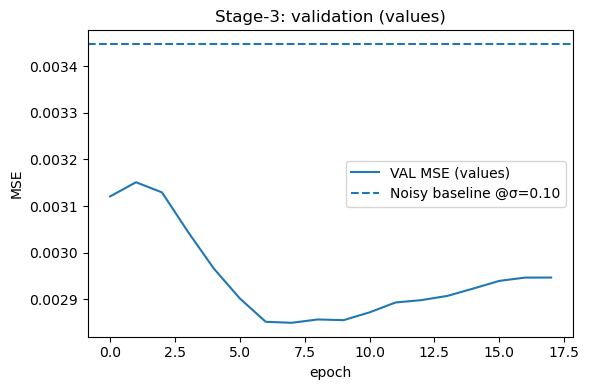

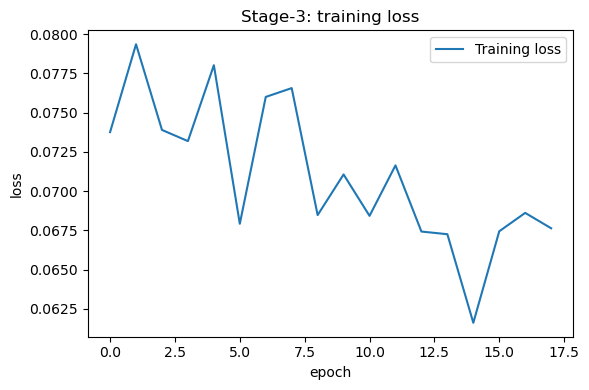

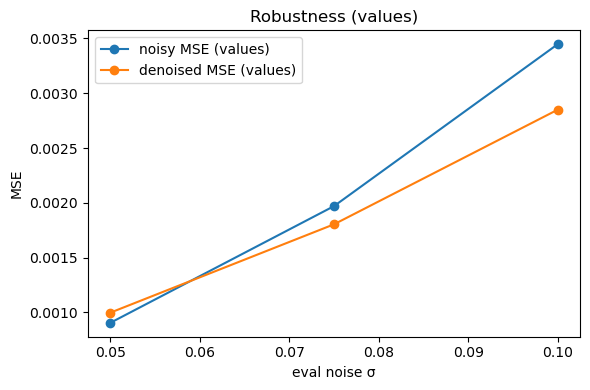

Robustness ΔMSE(values)% by eval noise:
  σ=0.050 → Δ=-10.2%
  σ=0.075 → Δ=+8.4%
  σ=0.100 → Δ=+17.3%


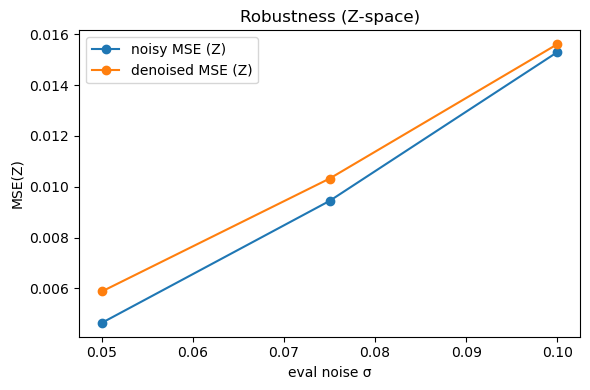

Robustness ΔMSE(Z)% by eval noise:
  σ=0.050 → Δ=-26.6%
  σ=0.075 → Δ=-9.3%
  σ=0.100 → Δ=-2.0%

VAL @ σ=0.10 → noisy=0.003447, deno=0.002850, Δ=+17.3%


In [510]:
# ================================
# Cell S3-5: validation curves & robustness scan (values-first)
# ================================
import numpy as np
import matplotlib.pyplot as plt

# 1) Validation curve (values) + training loss
noisy_baseline_val, _, _ = stage3_val_values_det(
    psi_stage3, X_val, sigma=EVAL_SIGMA, info=info, seeds=VAL_SEEDS
)

plt.figure(figsize=(6,4))
plt.plot(hist_val, label="VAL MSE (values)")
plt.axhline(noisy_baseline_val, ls="--", label=f"Noisy baseline @σ={EVAL_SIGMA:.2f}")
plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("Stage-3: validation (values)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist_train, label="Training loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Stage-3: training loss")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Robustness across eval noise (values space)
eval_grid = [0.05, 0.075, 0.10]
rob_noisy_v, rob_deno_v, rob_delta_v = [], [], []
for nl in eval_grid:
    mn, md, d = stage3_val_values_det(psi_stage3, X_val, sigma=nl, info=info, seeds=VAL_SEEDS)
    rob_noisy_v.append(mn); rob_deno_v.append(md); rob_delta_v.append(d)

plt.figure(figsize=(6,4))
plt.plot(eval_grid, rob_noisy_v, marker='o', label='noisy MSE (values)')
plt.plot(eval_grid, rob_deno_v, marker='o', label='denoised MSE (values)')
plt.xlabel("eval noise σ"); plt.ylabel("MSE"); plt.title("Robustness (values)")
plt.legend(); plt.tight_layout(); plt.show()

print("Robustness ΔMSE(values)% by eval noise:")
for nl, d in zip(eval_grid, rob_delta_v):
    print(f"  σ={nl:.3f} → Δ={d:+.1f}%")

# 3) Optional: Z-domain robustness (only if helper exists)
try:
    rob_noisy_z, rob_deno_z, rob_delta_z = [], [], []
    for nl in eval_grid:
        mn, md, d = stage3_val_metrics_Z_det(psi_stage3, X_val, nl, seeds=VAL_SEEDS, use_teacher=True)
        rob_noisy_z.append(mn); rob_deno_z.append(md); rob_delta_z.append(d)

    plt.figure(figsize=(6,4))
    plt.plot(eval_grid, rob_noisy_z, marker='o', label='noisy MSE (Z)')
    plt.plot(eval_grid, rob_deno_z, marker='o', label='denoised MSE (Z)')
    plt.xlabel("eval noise σ"); plt.ylabel("MSE(Z)"); plt.title("Robustness (Z-space)")
    plt.legend(); plt.tight_layout(); plt.show()

    print("Robustness ΔMSE(Z)% by eval noise:")
    for nl, d in zip(eval_grid, rob_delta_z):
        print(f"  σ={nl:.3f} → Δ={d:+.1f}%")
except NameError:
    print("(Z-space robustness skipped: stage3_val_metrics_Z_det not defined.)")

# 4) Headline metric at σ=0.10
mn, md, d = stage3_val_values_det(psi_stage3, X_val, sigma=0.10, info=info, seeds=VAL_SEEDS)
print(f"\nVAL @ σ=0.10 → noisy={mn:.6f}, deno={md:.6f}, Δ={d:+.1f}%")

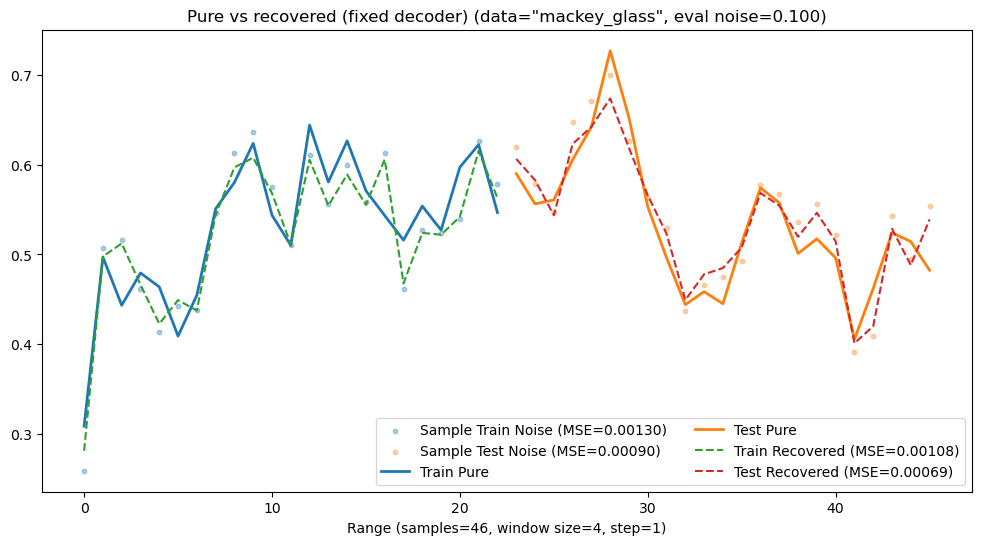

ΔMSE train: 16.8% | ΔMSE test:  23.5%


In [520]:
# ==== Value-domain helpers (decode all 4)  (FIXED) ====
def windows_with_noise(X_wins, noise_level):
    return np.stack([ts_add_noise_window(w, noise_level, info) for w in X_wins])

def predict_windows_decode_to_values(values_windows, psi, noise_level=None):
    noisy = (np.stack([ts_add_noise_window(w, noise_level, info) for w in values_windows])
             if noise_level is not None else np.asarray(values_windows))
    deno = []
    for n in noisy:
        z_all = np.array(denoiser_qnode_all(psi, n, info))   # 4 Z after fixed decoder
        deno.append(np.array(Z_to_values_autograd(z_all, info)))
    return noisy, np.stack(deno)  # shapes: (N,4), (N,4)

def flatten_avg(windows, step):
    windows = np.asarray(windows)
    W = windows.shape[1]; N = windows.shape[0]
    L = (N-1)*step + W
    acc = np.zeros(L); cnt = np.zeros(L)
    for i in range(N):
        s = i*step; e = s+W
        acc[s:e] += windows[i]; cnt[s:e] += 1.0
    return acc / np.maximum(cnt, 1e-12)

def flatten_all_to_common_len(windows_list, step):
    flats = [flatten_avg(w, step) for w in windows_list]
    L = min(len(a) for a in flats)
    flats = [a[:L] for a in flats]
    return flats, L

# ==== Build flattened series with full 4-wire decode ====
wind_step   = 1
noise_eval  = 0.1

noisy_train, deno_train = predict_windows_decode_to_values(X_train, psi_stage3, noise_eval)
noisy_test,  deno_test  = predict_windows_decode_to_values(X_test,  psi_stage3, noise_eval)

(flat_clean_train, flat_clean_test,
 flat_noisy_train, flat_noisy_test,
 flat_deno_train,  flat_deno_test), _ = flatten_all_to_common_len(
    [X_train, X_test, noisy_train, noisy_test, deno_train, deno_test], wind_step
)

from sklearn.metrics import mean_squared_error
mse_train_noise = mean_squared_error(flat_clean_train, flat_noisy_train)
mse_test_noise  = mean_squared_error(flat_clean_test,  flat_noisy_test)
mse_train_deno  = mean_squared_error(flat_clean_train, flat_deno_train)
mse_test_deno   = mean_squared_error(flat_clean_test,  flat_deno_test)

plt.figure(figsize=(12, 6))
N_train = len(flat_clean_train); idx_train = np.arange(N_train)
idx_test  = np.arange(N_train, N_train+len(flat_clean_test))
plt.scatter(idx_train, flat_noisy_train, s=10, alpha=0.35,
            label=f"Sample Train Noise (MSE={mse_train_noise:0.5f})")
plt.scatter(idx_test,  flat_noisy_test,  s=10, alpha=0.35,
            label=f"Sample Test Noise (MSE={mse_test_noise:0.5f})")
plt.plot(idx_train, flat_clean_train, label="Train Pure", linewidth=2)
plt.plot(idx_test,  flat_clean_test,  label="Test Pure",  linewidth=2)
plt.plot(idx_train, flat_deno_train, linestyle="--",
         label=f"Train Recovered (MSE={mse_train_deno:0.5f})")
plt.plot(idx_test,  flat_deno_test,   linestyle="--",
         label=f"Test Recovered (MSE={mse_test_deno:0.5f})")
plt.title(f'Pure vs recovered (fixed decoder) (data="{DATA_NAME}", eval noise={noise_eval:0.3f})')
plt.xlabel(f'Range (samples={len(flat_clean_train)+len(flat_clean_test)}, '
           f'window size={n_qubits}, step={wind_step})')
plt.legend(ncol=2); plt.show()

print(f"ΔMSE train: {100*(1 - mse_train_deno/max(mse_train_noise,1e-12)):.1f}% | "
      f"ΔMSE test:  {100*(1 - mse_test_deno /max(mse_test_noise ,1e-12)):.1f}%")

In [363]:
print(3*3*5)

45


In [523]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter

def monte_carlo_mse(psi, X_clean, noise_level, K=16):
    mses_noisy, mses_deno = [], []
    for _ in range(K):
        noisy, deno = predict_windows_decode_to_values(X_clean, psi, noise_level)
        flats, _ = flatten_all_to_common_len([X_clean, noisy, deno], step=1)
        clean_flat, noisy_flat, deno_flat = flats
        mses_noisy.append(mean_squared_error(clean_flat, noisy_flat))
        mses_deno.append(mean_squared_error(clean_flat, deno_flat))
    return np.mean(mses_noisy), np.std(mses_noisy), np.mean(mses_deno), np.std(mses_deno)

def baseline_ma(series, k=3):
    # centered moving average on the flattened noisy series
    x = np.array(series)
    pad = k//2
    xpad = np.pad(x, (pad,pad), mode='edge')
    out = np.convolve(xpad, np.ones(k)/k, mode='valid')
    return out

def eval_baselines(X_clean, noise_level, K=8, ma_k=5):
    mses_ma, mses_sg = [], []
    for _ in range(K):
        noisy, _ = predict_windows_decode_to_values(X_clean, psi_stage3, noise_level)
        (flat_clean, flat_noisy), _ = flatten_all_to_common_len([X_clean, noisy], step=1)
        # moving average
        ma = baseline_ma(flat_noisy, ma_k)
        mses_ma.append(mean_squared_error(flat_clean, ma))
        # Savitzky–Golay (order 2, window odd)
        win = ma_k if ma_k % 2 == 1 else ma_k+1
        sg = savgol_filter(flat_noisy, window_length=win, polyorder=2, mode='interp')
        mses_sg.append(mean_squared_error(flat_clean, sg))
    return np.mean(mses_ma), np.mean(mses_sg)

for nl in [0.10]:
    mn, sn, md, sd = monte_carlo_mse(psi_stage3, X_test, nl, K=32)
    ma_mse, sg_mse = eval_baselines(X_test, nl, K=16, ma_k=5)
    print(f"noise={nl:.3f} | noisy {mn:.6f}±{sn:.6f} | deno {md:.6f}±{sd:.6f} | "
          f"MA5 {ma_mse:.6f} | SG {sg_mse:.6f} | Δ vs noisy = {100*(1-md/max(mn,1e-12)):.1f}%")

noise=0.100 | noisy 0.001183±0.000318 | deno 0.001095±0.000333 | MA5 0.001732 | SG 0.000944 | Δ vs noisy = 7.4%


In [524]:
# 1) Misalignment control: shuffle windows before decoding -> MSE should explode if you were *not* cheating.
def misalignment_control(psi, wins, noise_level):
    noisy, deno = [], []
    for w in wins:
        n = ts_add_noise_window(w, noise_level, info)
        z = np.array(denoiser_qnode_all(psi, n, info))
        deno.append(np.array(Z_to_values_autograd(z, info)))
        noisy.append(n)
    deno = np.stack(deno); noisy = np.stack(noisy)
    # shuffle the denoised windows (break alignment)
    deno_shuf = deno.copy()
    np.random.shuffle(deno_shuf)
    from sklearn.metrics import mean_squared_error
    return mean_squared_error(wins.ravel(), deno.ravel()), \
           mean_squared_error(wins.ravel(), deno_shuf.ravel())

mse_aligned, mse_misaligned = misalignment_control(psi_stage3, X_test, 0.1)
print("Aligned MSE vs misaligned MSE:", mse_aligned, mse_misaligned)
# Expect: misaligned >> aligned. If they’re similar, you’re “connecting dots.”

Aligned MSE vs misaligned MSE: 0.0032324881736797524 0.04075930648413434


In [527]:
# 2) Two-draw consistency (latent): large numbers mean you chase noise.
def latent_consistency_score(psi, wins, noise_level):
    diffs = []
    for w in wins:
        n1 = ts_add_noise_window(w, noise_level, info)
        n2 = ts_add_noise_window(w, noise_level, info)
        z1 = np.array(encoder_only_expZ_all(psi, n1, info))[:n_latent]
        z2 = np.array(encoder_only_expZ_all(psi, n2, info))[:n_latent]
        diffs.append(np.mean(np.abs(z1 - z2)))
    return float(np.mean(diffs))
print("Latent consistency @0.1:", latent_consistency_score(psi_stage3, X_val, 0.1))

Latent consistency @0.1: 0.11386914177881377


In [534]:
# 3) “Are we moving toward clean or just smoothing?” — residual correlation.
# corr( (pure - noisy), (recovered - noisy) ) should be strongly positive.
def residual_corr(psi, wins, noise_level):
    num, den1, den2 = 0.0, 0.0, 0.0
    for w in wins:
        n = ts_add_noise_window(w, noise_level, info)
        z = np.array(denoiser_qnode_all(psi, n, info))
        r = np.array(Z_to_values_autograd(z, info)) - n
        t = np.asarray(w) - n
        num  += np.dot(r, t)
        den1 += np.dot(r, r)
        den2 += np.dot(t, t)
    import math
    return num / (math.sqrt(den1*den2) + 1e-12)
print("Residual correlation @0.1:", residual_corr(psi_stage3, X_test, 0.1))

Residual correlation @0.1: 0.46733068774790776



[TRAIN]  ΔMSE% (values): mean=  9.76  95%CI=(  0.58, 18.70)  sign-test p=0.0005
[TRAIN]  ΔMSE% (Z):      mean=-26.61  95%CI=(-54.08, -1.19)  sign-test p=1.0000


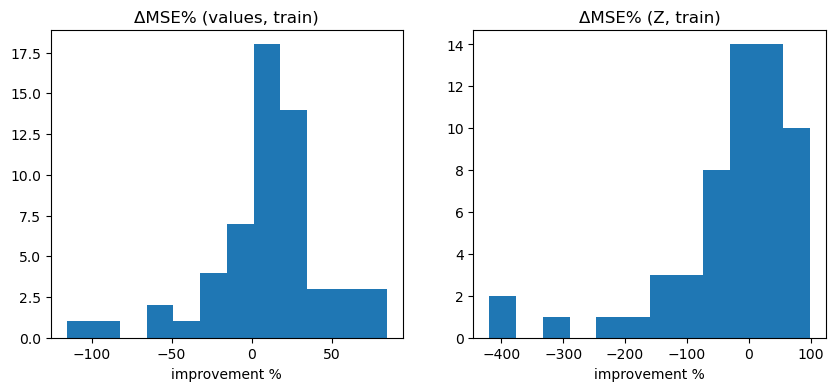


[VAL]  ΔMSE% (values): mean=  8.00  95%CI=(-13.11, 25.61)  sign-test p=0.0026
[VAL]  ΔMSE% (Z):      mean=-66.06  95%CI=(-155.11, -7.46)  sign-test p=0.2632


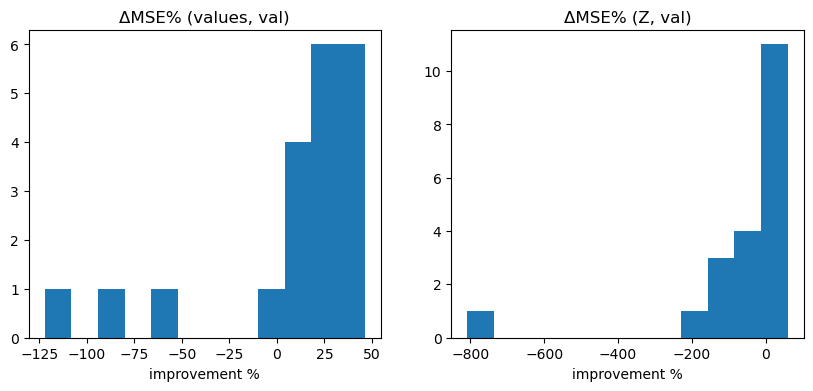


[TEST]  ΔMSE% (values): mean=  6.54  95%CI=( -3.61, 16.36)  sign-test p=0.2632
[TEST]  ΔMSE% (Z):      mean=  2.59  95%CI=(-33.50, 32.89)  sign-test p=0.5034


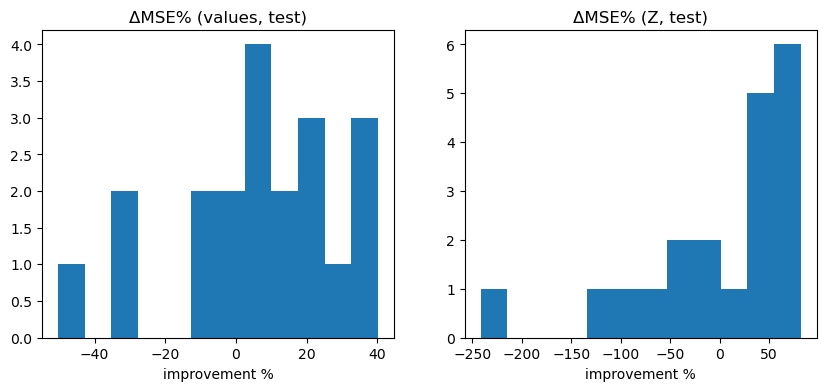

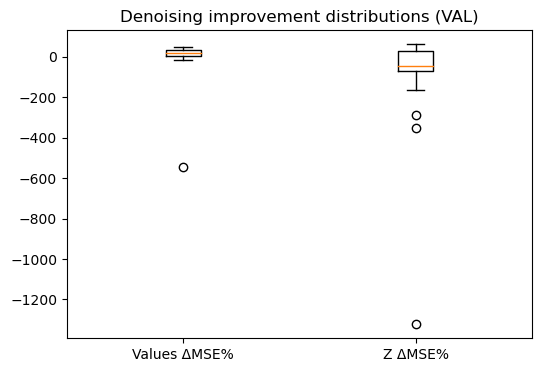

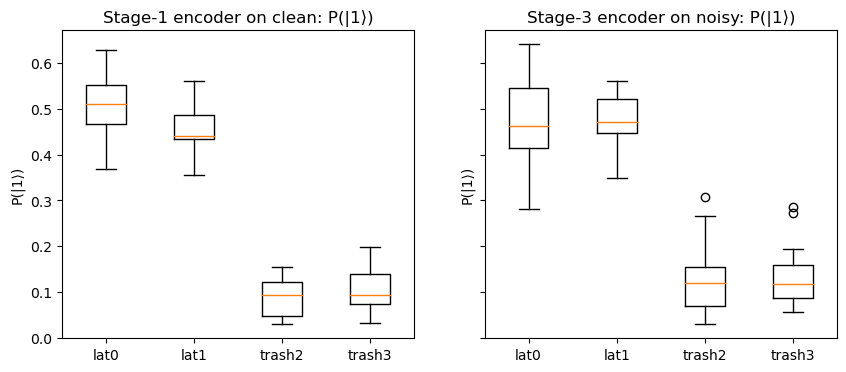

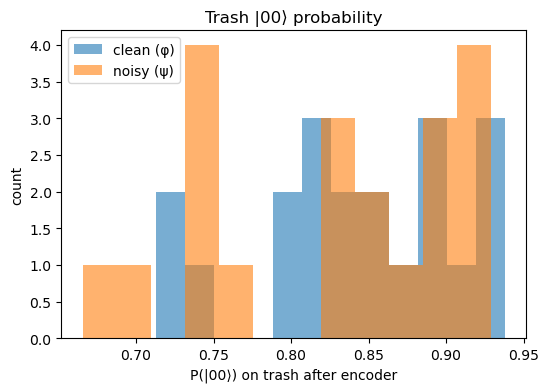

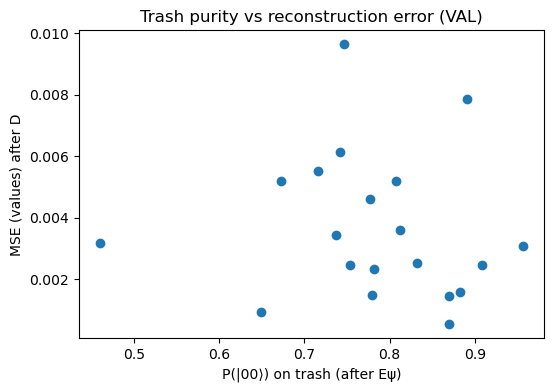

Corr(P00, MSE) on VAL: -0.106


In [538]:
# ================================
# Cell S3-7: insight tests & plots (FIXED)
# ================================
import numpy as np
import matplotlib.pyplot as plt
import math

# --- helpers reused here (numpy versions) ---
def Z_to_values(z_all, info):
    """Inverse of RY(π·v01) readout: z = cos(π v01) -> v01 = arccos(z)/π -> [lo,hi]."""
    z_all = np.clip(np.asarray(z_all, dtype=float), -0.999999, 0.999999)
    v01   = np.arccos(z_all) / np.pi
    return v01 * (info["scale_high"] - info["scale_low"]) + info["scale_low"]

def p1_from_expZ_np(z):
    return (1.0 - np.asarray(z, dtype=float)) * 0.5

# QNode wrappers already defined earlier:
# - teacher_code_latents(x, info)             -> ⟨Z⟩ on LATENT wires after fixed E_φ
# - code_signal_after_encoder_student(ψ,x,info)-> ⟨Z⟩ on LATENT wires after E_ψ
# - denoiser_qnode_all(ψ, x, info)            -> ⟨Z⟩ on ALL 4 after E_ψ → D_φ†
# - encoder_only_expZ_all(params, x, info)     -> ⟨Z⟩ on ALL 4 after encoder only
# - trash_probs_after_encoder(params, x, info) -> Probs on trash wires (we defined this in S3-2)

def eval_window_sets(psi, X, noise_level=0.06):
    """
    Returns arrays per-window:
      (mse_noisy_Z, mse_deno_Z, mse_noisy_val, mse_deno_val, deltaZ%, deltaVal%)

    Z-domain: compare teacher latents E_φ(clean) vs E_φ(noisy) and vs E_ψ(noisy).
    Value-domain: decode ALL 4 wires through fixed D and inverse-readout to values.
    """
    mZ_noisy, mZ_deno, mV_noisy, mV_deno, dZ, dV = [], [], [], [], [], []
    eps = 1e-9

    for c in X:
        n = ts_add_noise_window(c, noise_level, info)

        # --- Z-domain (teacher vs student) ---
        z_clean = np.array(teacher_code_latents(c, info))     # E_φ(clean) on latents
        z_noisy = np.array(teacher_code_latents(n, info))     # E_φ(noisy)
        z_deno  = np.array(code_signal_after_encoder_student(psi, n, info))  # E_ψ(noisy)

        mse_nZ = float(np.mean((z_clean - z_noisy)**2))
        mse_dZ = float(np.mean((z_clean - z_deno )**2))
        mZ_noisy.append(mse_nZ); mZ_deno.append(mse_dZ)
        dZ.append(100.0 * ((mse_nZ - mse_dZ) / max(mse_nZ, eps)))  # positive = improvement

        # --- Value-domain (decode all 4) ---
        z_all_d = np.array(denoiser_qnode_all(psi, n, info))  # 4 Z's after D
        v_deno  = np.array(Z_to_values(z_all_d, info))        # -> 4 values
        v_clean = np.array(c); v_noisy = np.array(n)

        mse_nV = float(np.mean((v_clean - v_noisy)**2))
        mse_dV = float(np.mean((v_clean - v_deno )**2))
        mV_noisy.append(mse_nV); mV_deno.append(mse_dV)
        dV.append(100.0 * ((mse_nV - mse_dV) / max(mse_nV, eps)))  # positive = improvement

    return (np.array(mZ_noisy), np.array(mZ_deno),
            np.array(mV_noisy), np.array(mV_deno),
            np.array(dZ), np.array(dV))

rng = np.random.default_rng(2025)

def bootstrap_ci_mean(x, B=3000, alpha=0.05):
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n == 0:
        return 0.0, 0.0, 0.0
    xb = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        xb.append(np.mean(x[idx]))
    xb = np.sort(xb)
    lo = xb[int((alpha/2)*B)]
    hi = xb[int((1 - alpha/2)*B) - 1]
    return float(np.mean(x)), float(lo), float(hi)

def sign_test_pvalue(diffs):
    """Two-sided exact sign test for paired improvement (diff = noisy - denoised)."""
    diffs = np.asarray(diffs, dtype=float)
    pos = int(np.sum(diffs > 0))
    neg = int(np.sum(diffs < 0))
    n   = pos + neg
    if n == 0: 
        return 1.0
    def binom_pmf(n,k): return math.comb(n,k) / (2**n)
    tail = sum(binom_pmf(n, k) for k in range(0, min(pos,neg)+1))
    return float(min(1.0, 2*tail))

# ---------- Evaluate on train / val / test ----------
for name, Xset in [("train", X_train), ("val", X_val), ("test", X_test)]:
    mZ_n, mZ_d, mV_n, mV_d, dZ, dV = eval_window_sets(psi_stage3, Xset, noise_level=noise_eval)

    # bootstrap CIs & paired sign tests
    mean_dV, lo_dV, hi_dV = bootstrap_ci_mean(dV, B=3000, alpha=0.05)
    mean_dZ, lo_dZ, hi_dZ = bootstrap_ci_mean(dZ, B=3000, alpha=0.05)
    p_val_V = sign_test_pvalue(mV_n - mV_d)   # noisy - deno
    p_val_Z = sign_test_pvalue(mZ_n - mZ_d)

    print(f"\n[{name.upper()}]  ΔMSE% (values): mean={mean_dV:6.2f}  95%CI=({lo_dV:6.2f},{hi_dV:6.2f})  sign-test p={p_val_V:.4f}")
    print(f"[{name.upper()}]  ΔMSE% (Z):      mean={mean_dZ:6.2f}  95%CI=({lo_dZ:6.2f},{hi_dZ:6.2f})  sign-test p={p_val_Z:.4f}")

    # histograms
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].hist(dV, bins=12); ax[0].set_title(f"ΔMSE% (values, {name})"); ax[0].set_xlabel("improvement %")
    ax[1].hist(dZ, bins=12); ax[1].set_title(f"ΔMSE% (Z, {name})"); ax[1].set_xlabel("improvement %")
    plt.show()

# ---------- Boxplot summary on VAL ----------
mZ_n, mZ_d, mV_n, mV_d, dZ, dV = eval_window_sets(psi_stage3, X_val, noise_level=noise_eval)
plt.figure(figsize=(6,4))
plt.boxplot([dV, dZ], labels=["Values ΔMSE%", "Z ΔMSE%"])
plt.title("Denoising improvement distributions (VAL)")
plt.show()

# ---------- P(|1>) per wire: Stage-1 on clean vs Stage-3 on noisy ----------
# Stage-1 encoder on clean
p1_clean = np.array([p1_from_expZ_np(encoder_only_expZ_all(phi_stage1, c, info)) for c in X_val])  # (N,4)
# Stage-3 encoder on noisy
p1_noisy = np.array([p1_from_expZ_np(encoder_only_expZ_all(psi_stage3, ts_add_noise_window(c, noise_eval, info), info))
                     for c in X_val])

labels = ["lat0","lat1","trash2","trash3"]
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax[0].boxplot([p1_clean[:,i] for i in range(4)], labels=labels); ax[0].set_title("Stage-1 encoder on clean: P(|1⟩)")
ax[1].boxplot([p1_noisy[:,i] for i in range(4)], labels=labels); ax[1].set_title("Stage-3 encoder on noisy: P(|1⟩)")
for a in ax: a.set_ylabel("P(|1⟩)")
plt.show()

# ---------- Trash |00⟩ histogram (clean vs noisy via Stage-3 encoder) ----------
P00_clean, P00_noisy = [], []
for c in X_val:
    P = np.array(trash_probs_after_encoder(phi_stage1, c, info))
    P00_clean.append(P[0])
    P = np.array(trash_probs_after_encoder(psi_stage3, ts_add_noise_window(c, noise_eval, info), info))
    P00_noisy.append(P[0])

plt.figure(figsize=(6,4))
plt.hist(P00_clean, bins=12, alpha=0.6, label="clean (φ)")
plt.hist(P00_noisy, bins=12, alpha=0.6, label="noisy (ψ)")
plt.xlabel("P(|00⟩) on trash after encoder"); plt.ylabel("count"); plt.title("Trash |00⟩ probability")
plt.legend(); plt.show()

# ---------- Trash purity vs reconstruction error (VAL) ----------
errs, p00s = [], []
for c in X_val:
    n = ts_add_noise_window(c, noise_eval, info)
    P = np.array(trash_probs_after_encoder(psi_stage3, n, info))
    p00s.append(P[0])
    z_all_d = np.array(denoiser_qnode_all(psi_stage3, n, info))
    v_deno  = np.array(Z_to_values(z_all_d, info))
    errs.append(np.mean((np.asarray(c) - v_deno)**2))

plt.figure(figsize=(6,4))
plt.scatter(p00s, errs)
plt.xlabel("P(|00⟩) on trash (after Eψ)"); plt.ylabel("MSE (values) after D")
plt.title("Trash purity vs reconstruction error (VAL)")
plt.show()

if len(p00s) > 1:
    corr = float(np.corrcoef(p00s, errs)[0,1])
    print(f"Corr(P00, MSE) on VAL: {corr:+.3f}")

In [539]:
# ================================
# Cell A: SAVE MODEL BUNDLE (JSON only)
# ================================
import os, json, time
from pathlib import Path
import numpy as np

def _ensure_dir(p): Path(p).mkdir(parents=True, exist_ok=True); return p
def _tolist(x):
    if x is None: return None
    try: return np.asarray(x).tolist()
    except Exception: return x

# ---- required objects expected in memory ----
assert "info" in globals(), "Missing 'info' dict."
assert "phi_stage1" in globals(), "Missing 'phi_stage1' (teacher encoder params)."
assert "psi_stage3" in globals(), "Missing 'psi_stage3' (student/denoiser params)."

# ---- identifiers / metadata (best-effort fallbacks) ----
DATASET_ID  = globals().get("data_name", None) or info.get("dataset_id", "unknown_dataset")
RUN_TAG     = globals().get("RUN_TAG", None) or time.strftime("%Y%m%d-%H%M%S")
SEED        = globals().get("seed", globals().get("RUN_SEED", None))
SIG_TRAIN   = float(globals().get("noise_train", globals().get("noise_eval", 0.10)))
SIG_EVAL    = float(globals().get("noise_eval", SIG_TRAIN))
USER_NOTE   = globals().get("RUN_NOTE", None)

# ---- architecture (from info, with sane defaults) ----
latent_idx  = list(info.get("latent_wires", [0,1]))
trash_idx   = list(info.get("trash_wires",  [2,3]))

bundle = {
    "schema": {"name": "qae_model_bundle", "version": "1.0"},
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "dataset": {
        "id": DATASET_ID,
        "scale_low":  float(info.get("scale_low",  0.0)),
        "scale_high": float(info.get("scale_high", 1.0)),
        "n_samples": int(info.get("n_samples", -1)),
        "window_size": int(info.get("window_size", 4)),
        "window_stride": int(info.get("window_stride", 1)),
    },
    "run": {
        "tag": RUN_TAG,
        "seed": SEED,
        "regime": "stage3_fixed_decoder_denoiser",
        "sigma_train": SIG_TRAIN,
        "sigma_eval":  SIG_EVAL,
        "user_note": USER_NOTE,
    },
    "architecture": {
        "n_qubits": int(info.get("n_qubits", 4)),
        "n_layers": int(info.get("n_layers", 3)),
        "latent_wires": latent_idx,
        "trash_wires":  trash_idx,
        "n_latent": len(latent_idx),
        "n_trash":  len(trash_idx),
    },
    "parameters": {
        "phi_stage1": _tolist(phi_stage1),
        "psi_stage3": _tolist(psi_stage3),
    },
    # optional training curves if you have them (won't break if missing)
    "training_history": {
        "val_mse_values": globals().get("hist_val_values", None),
        "train_loss":     globals().get("hist_train_loss", None),
        "lr":             globals().get("hist_lr", None),
    },
}

BASE_DIR = _ensure_dir(os.path.join("./runs_qae", DATASET_ID, f"run_{RUN_TAG}"))
BUNDLE_JSON = os.path.join(BASE_DIR, "model_bundle.json")
with open(BUNDLE_JSON, "w") as f:
    json.dump(bundle, f, indent=2)

print(f"Saved model bundle JSON → {BUNDLE_JSON}")

Saved model bundle JSON → ./runs_qae/unknown_dataset/run_20250824-171313/model_bundle.json


In [541]:
# ================================
# Cell B (fixed): save one "instance record" JSON with robust metrics
# ================================
import json, time, hashlib, numpy as np, math, os
from copy import deepcopy

SAVE_RAW_PER_WINDOW = False  # keep files small by default
OUT_DIR = info.get("run_dir", ".")
os.makedirs(OUT_DIR, exist_ok=True)
record_path = os.path.join(OUT_DIR, "instance_record.json")

# ---- helpers (lightweight, numpy-safe) ----
rng = np.random.default_rng(1234)

def bootstrap_ci_mean(x, B=3000, alpha=0.05):
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return 0.0, 0.0, 0.0
    n = x.size
    xb = np.empty(B, dtype=float)
    for i in range(B):
        idx = rng.integers(0, n, size=n)
        xb[i] = float(np.mean(x[idx]))
    xb.sort()
    lo = xb[int((alpha/2)*B)]
    hi = xb[int((1 - alpha/2)*B) - 1]
    return float(np.mean(x)), float(lo), float(hi)

def sign_test(diffs):
    """Paired sign test counts + two-sided p-value on 'diffs' (noisy - deno)."""
    diffs = np.asarray(diffs, dtype=float)
    wins  = int(np.sum(diffs > 0))  # deno < noisy
    losses= int(np.sum(diffs < 0))
    ties  = int(np.sum(diffs == 0))
    n     = wins + losses
    if n == 0:
        return wins, losses, ties, 1.0
    # exact binomial tail
    def pmf(n,k): return math.comb(n,k) / (2**n)
    tail = sum(pmf(n,k) for k in range(0, min(wins, losses)+1))
    pval = min(1.0, 2*tail)
    return wins, losses, ties, float(pval)

def to_py(obj):
    """Recursively convert numpy types to plain Python for JSON."""
    if isinstance(obj, (np.floating, np.float32, np.float64)): return float(obj)
    if isinstance(obj, (np.integer, np.int32, np.int64)):      return int(obj)
    if isinstance(obj, (np.ndarray,)):                         return [to_py(v) for v in obj.tolist()]
    if isinstance(obj, (list, tuple)):                         return [to_py(v) for v in obj]
    if isinstance(obj, dict):                                   return {k: to_py(v) for k,v in obj.items()}
    return obj

# ---- evaluation wrapper (values & Z) ----
def eval_window_sets(psi, X, noise_level):
    """
    Returns dict with:
      mZ_noisy, mZ_deno, mV_noisy, mV_deno : per-window arrays
      dZ_rel, dV_rel : per-window Δ% using (noisy) as denominator with floor
      dZ_sym, dV_sym : per-window symmetric % change (bounded; robust)
    Uses:
      - teacher_code_latents(c, info)           # E_φ on latents
      - code_signal_after_encoder_student(psi)  # E_ψ on latents
      - denoiser_qnode_all(psi, ...)            # all 4 Z after D
      - Z_to_values(z_all, info)                # inverse readout to values
      - ts_add_noise_window(c, sigma, info)
    """
    mZ_n, mZ_d, mV_n, mV_d = [], [], [], []
    dZ_rel, dV_rel, dZ_sym, dV_sym = [], [], [], []
    eps = 1e-12

    # First pass to get a stable denominator floor per split
    tmp_noisy_vals = []
    for c in X:
        n = ts_add_noise_window(c, noise_level, info)
        v_clean = np.array(c); v_noisy = np.array(n)
        tmp_noisy_vals.append(float(np.mean((v_clean - v_noisy)**2)))
    tmp_noisy_vals = np.asarray(tmp_noisy_vals, dtype=float)
    # Use a percentile-based floor to avoid tiny denominators dominating the mean
    denom_floor_vals = max(np.percentile(tmp_noisy_vals, 10), 1e-8)

    # Optional: a separate floor for Z (usually less critical)
    denom_floor_Z = denom_floor_vals

    for c in X:
        n = ts_add_noise_window(c, noise_level, info)

        # --- Z-domain (latents only)
        z_clean = np.array(teacher_code_latents(c, info))
        z_noisy = np.array(teacher_code_latents(n, info))
        z_deno  = np.array(code_signal_after_encoder_student(psi, n, info))
        mse_nZ  = float(np.mean((z_clean - z_noisy)**2))
        mse_dZ  = float(np.mean((z_clean - z_deno )**2))
        mZ_n.append(mse_nZ); mZ_d.append(mse_dZ)

        # relative (% of noisy) with floor
        denomZ = max(mse_nZ, denom_floor_Z)
        dZ_rel.append(100.0 * (mse_nZ - mse_dZ) / denomZ)
        # symmetric % change (bounded, robust to tiny denominators)
        dZ_sym.append(200.0 * (mse_nZ - mse_dZ) / (abs(mse_nZ) + abs(mse_dZ) + eps))

        # --- Value-domain (decode all 4)
        z_all_d = np.array(denoiser_qnode_all(psi, n, info))
        v_deno  = np.array(Z_to_values(z_all_d, info))
        v_clean = np.array(c); v_noisy = np.array(n)
        mse_nV  = float(np.mean((v_clean - v_noisy)**2))
        mse_dV  = float(np.mean((v_clean - v_deno )**2))
        mV_n.append(mse_nV); mV_d.append(mse_dV)

        denomV = max(mse_nV, denom_floor_vals)
        dV_rel.append(100.0 * (mse_nV - mse_dV) / denomV)
        dV_sym.append(200.0 * (mse_nV - mse_dV) / (abs(mse_nV) + abs(mse_dV) + eps))

    return {
        "mZ_noisy": np.array(mZ_n), "mZ_deno": np.array(mZ_d),
        "mV_noisy": np.array(mV_n), "mV_deno": np.array(mV_d),
        "dZ_rel": np.array(dZ_rel), "dV_rel": np.array(dV_rel),
        "dZ_sym": np.array(dZ_sym), "dV_sym": np.array(dV_sym),
        "denom_floor_vals": float(denom_floor_vals),
        "denom_floor_Z": float(denom_floor_Z),
    }

def summarize_split(res):
    """Aggregate split metrics and tests for values and Z, reporting multiple Δ% definitions."""
    out = {}
    for dom, keys in [
        ("values", ("mV_noisy","mV_deno","dV_rel","dV_sym")),
        ("Z",      ("mZ_noisy","mZ_deno","dZ_rel","dZ_sym")),
    ]:
        noisy = res[keys[0]]; deno = res[keys[1]]
        d_rel = res[keys[2]]; d_sym = res[keys[3]]

        eps = 1e-12
        mean_noisy = float(np.mean(noisy))
        mean_deno  = float(np.mean(deno))
        pooled_delta_pct = 100.0 * (mean_noisy - mean_deno) / max(mean_noisy, eps)

        # CI for per-window variants
        rel_mean, rel_lo, rel_hi = bootstrap_ci_mean(d_rel, B=3000, alpha=0.05)
        sym_mean, sym_lo, sym_hi = bootstrap_ci_mean(d_sym, B=3000, alpha=0.05)

        wins, losses, ties, pval = sign_test(noisy - deno)

        out[dom] = {
            "noisy_MSE_mean": mean_noisy,
            "deno_MSE_mean":  mean_deno,
            "delta_MSE_pct_pooled": float(pooled_delta_pct),

            "delta_MSE_pct_mean_per_window": float(rel_mean),
            "delta_MSE_pct_CI95_per_window": [float(rel_lo), float(rel_hi)],

            "delta_MSE_pct_symmetric_mean": float(sym_mean),
            "delta_MSE_pct_symmetric_CI95": [float(sym_lo), float(sym_hi)],

            "sign_test": {"wins": wins, "losses": losses, "ties": ties, "p_value": pval},

            "noisy_MSE_std": float(np.std(noisy)),
            "deno_MSE_std":  float(np.std(deno)),
        }
    return out

# ---- run evals on all splits at the primary eval sigma ----
splits = {
    "train": eval_window_sets(psi_stage3, X_train, noise_eval),
    "val":   eval_window_sets(psi_stage3, X_val,   noise_eval),
    "test":  eval_window_sets(psi_stage3, X_test,  noise_eval),
}
summary = {k: summarize_split(v) for k, v in splits.items()}

# ---- robustness on VAL across a grid (report pooled + per-window symmetric) ----
rob_grid = info.get("robust_eval_grid", [0.05, 0.075, 0.10])
robust = []
for s in rob_grid:
    r = eval_window_sets(psi_stage3, X_val, s)
    # pooled
    mean_noisy = float(np.mean(r["mV_noisy"]))
    mean_deno  = float(np.mean(r["mV_deno"]))
    pooled = 100.0 * (mean_noisy - mean_deno) / max(mean_noisy, 1e-12)
    # per-window (relative & symmetric)
    dv_rel_mean, dv_rel_lo, dv_rel_hi = bootstrap_ci_mean(r["dV_rel"])
    dv_sym_mean, dv_sym_lo, dv_sym_hi = bootstrap_ci_mean(r["dV_sym"])
    dz_rel_mean, dz_rel_lo, dz_rel_hi = bootstrap_ci_mean(r["dZ_rel"])
    dz_sym_mean, dz_sym_lo, dz_sym_hi = bootstrap_ci_mean(r["dZ_sym"])

    robust.append({
        "sigma": float(s),

        "values_delta_pct_pooled": float(pooled),

        "values_delta_pct_mean_per_window": float(dv_rel_mean),
        "values_delta_pct_CI95_per_window": [float(dv_rel_lo), float(dv_rel_hi)],

        "values_delta_pct_symmetric_mean": float(dv_sym_mean),
        "values_delta_pct_symmetric_CI95": [float(dv_sym_lo), float(dv_sym_hi)],

        "Z_delta_pct_mean_per_window": float(dz_rel_mean),
        "Z_delta_pct_CI95_per_window": [float(dz_rel_lo), float(dz_rel_hi)],

        "Z_delta_pct_symmetric_mean": float(dz_sym_mean),
        "Z_delta_pct_symmetric_CI95": [float(dz_sym_lo), float(dz_sym_hi)],

        "denom_floor_vals": r["denom_floor_vals"],
        "denom_floor_Z": r["denom_floor_Z"],
    })

# ---- a couple of diagnostics (kept lean) ----
aligned_vs_misaligned = {
    "aligned_values_MSE": float(info.get("aligned_mse_values", np.nan)),
    "misaligned_values_MSE": float(info.get("misaligned_mse_values", np.nan)),
}
corr_p00 = float(info.get("corr_P00_vs_MSE_val", np.nan))
latent_consistency = float(info.get("latent_consistency_at_sigma", np.nan))
residual_corr = float(info.get("residual_corr_at_sigma", np.nan))

# ---- param fingerprint (identity)
def params_bytes(params):
    buf = bytearray()
    def _walk(p):
        if isinstance(p, (list, tuple)):
            for q in p: _walk(q)
        elif isinstance(p, np.ndarray):
            buf.extend(np.asarray(p, dtype=np.float64).tobytes())
        elif isinstance(p, (float, int, np.floating, np.integer)):
            buf.extend(np.asarray([p], dtype=np.float64).tobytes())
        elif p is None:
            buf.extend(b"\x00")
        else:
            buf.extend(str(p).encode("utf-8"))
    _walk(psi_stage3)  # trained params object
    return bytes(buf)

param_fingerprint = hashlib.sha256(params_bytes(psi_stage3)).hexdigest()

# ---- assemble the record ----
record = {
    "meta": {
        "run_id": info.get("run_id", f"run_{int(time.time())}"),
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
        "dataset_id": info.get("dataset_id", "unknown"),
        "window": {"size": info.get("window_size", None), "stride": info.get("window_stride", None)},
        "scaling": {"low": info.get("scale_low", None), "high": info.get("scale_high", None)},
        "noise_sigma_train": float(info.get("noise_sigma_train", np.nan)),
        "noise_sigma_eval":  float(noise_eval),
        "splits": {
            "n_train": len(X_train), "n_val": len(X_val), "n_test": len(X_test)
        },
        "seed": int(info.get("seed", -1)),
    },
    "architecture": {
        "n_qubits_total": int(info.get("n_qubits", 4)),
        "n_latent": int(info.get("n_latent", 2)),
        "n_trash":  int(info.get("n_trash", 2)),
        "latent_wires": to_py(info.get("latent_wires", [0,1])),
        "trash_wires":  to_py(info.get("trash_wires",  [2,3])),
        "n_layers": int(info.get("n_layers", 3)),
        "param_counts": {
            "phi": int(info.get("param_count_phi", -1)),
            "psi": int(info.get("param_count_psi", -1)),
        },
        "param_fingerprint": param_fingerprint,
    },
    "training_setup": {
        "optimizer": info.get("optimizer_name", "adam"),
        "init_lr": float(info.get("init_lr", 0.003)),
        "lr_schedule": info.get("lr_schedule", "plateau/halving"),
        "batch_size": int(info.get("batch_size", 0)),
        "weight_decay": float(info.get("weight_decay", 0.0)),
        "max_epochs": int(info.get("max_epochs", 0)),
        "patience":   int(info.get("patience", 0)),
    },
    "training_outcome": {
        "best_epoch": int(info.get("best_epoch", -1)),
        "early_stopped": bool(info.get("early_stopped", True)),
        "val_mse_values_best": to_py(info.get("val_mse_values_best", np.nan)),
    },
    "metrics": summary,       # per-split summaries: pooled & per-window variants
    "robustness_val": robust, # grid of sigmas with pooled + per-window symmetric
    "diagnostics": {
        "aligned_vs_misaligned_values_MSE": aligned_vs_misaligned,
        "corr_P00_vs_MSE_val": corr_p00,
        "latent_consistency": latent_consistency,
        "residual_noise_corr": residual_corr,
    },
    "artifacts": {
        "model_bundle_json": info.get("model_bundle_path", None),
        "instance_record_json": record_path,
    }
}

# Optionally stash raw arrays (can get big!)
if SAVE_RAW_PER_WINDOW:
    record["raw_per_window"] = {
        split: {
            "values": {
                "noisy_MSE": to_py(splits[split]["mV_noisy"]),
                "deno_MSE":  to_py(splits[split]["mV_deno"]),
                "delta_pct_rel": to_py(splits[split]["dV_rel"]),
                "delta_pct_sym": to_py(splits[split]["dV_sym"]),
            },
            "Z": {
                "noisy_MSE": to_py(splits[split]["mZ_noisy"]),
                "deno_MSE":  to_py(splits[split]["mZ_deno"]),
                "delta_pct_rel": to_py(splits[split]["dZ_rel"]),
                "delta_pct_sym": to_py(splits[split]["dZ_sym"]),
            },
        } for split in ["train","val","test"]
    }

# save
with open(record_path, "w") as f:
    json.dump(to_py(record), f, indent=2)

print(f"Saved instance record → {record_path}")

Saved instance record → ./instance_record.json


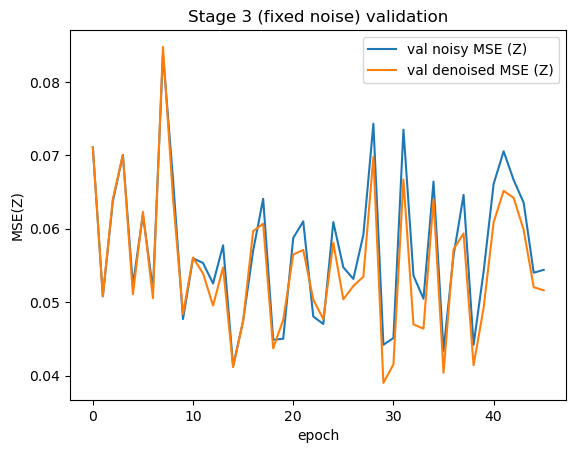

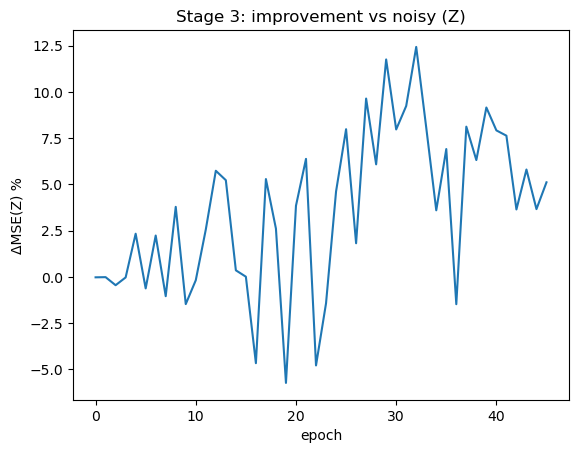

TypeError: stage3_val_metrics_Z() got an unexpected keyword argument 'noise_level'

In [137]:
# ==== Stage 3: validation curves & robustness (fixed eval noise) ====
plt.figure()
plt.plot(hist_noisyZ, label="val noisy MSE (Z)")
plt.plot(hist_valZ,  label="val denoised MSE (Z)")
plt.xlabel("epoch"); plt.ylabel("MSE(Z)")
plt.title("Stage 3 (fixed noise) validation")
plt.legend(); plt.show()

plt.figure()
plt.plot(hist_deltaZ); plt.xlabel("epoch"); plt.ylabel("ΔMSE(Z) %")
plt.title("Stage 3: improvement vs noisy (Z)"); plt.show()

# Robustness scan
eval_grid = [0.05, 0.075, 0.10]
rob_noisy, rob_deno, rob_delta = [], [], []
for nl in eval_grid:
    mn, md, dZ = stage3_val_metrics_Z(psi_stage3, X_val, noise_level=nl)
    rob_noisy.append(mn); rob_deno.append(md); rob_delta.append(dZ)

plt.figure(figsize=(6,4))
plt.plot(eval_grid, rob_noisy, marker='o', label='noisy MSE(Z)')
plt.plot(eval_grid, rob_deno, marker='o', label='denoised MSE(Z)')
plt.xlabel("eval noise"); plt.ylabel("MSE(Z)")
plt.title("Stage 3 (fixed noise) robustness (Z-domain)")
plt.legend(); plt.show()

print("Robustness ΔMSE(Z)% by eval noise:")
for nl, dZ in zip(eval_grid, rob_delta):
    print(f"  noise={nl:.3f} → ΔMSE(Z)={dZ:.1f}%")

# Quick value-domain summary at fixed noise using FULL decode
mse_noisy_vals, mse_deno_vals = [], []
for c in X_val:
    n  = ts_add_noise_window(c, noise_eval)
    z_all = np.array(denoiser_qnode_all(psi_stage3, n))  # 4 wires
    v_d   = np.array(Z_to_values(z_all))                 # -> 4 values
    mse_noisy_vals.append(np.mean((np.array(c)-np.array(n))**2))
    mse_deno_vals.append(np.mean((np.array(c)-v_d)**2))

mse_noisy_vals = float(np.mean(mse_noisy_vals))
mse_deno_vals  = float(np.mean(mse_deno_vals))
delta_val = 100.0*(1.0 - mse_deno_vals/max(mse_noisy_vals,1e-12))
print(f"[Stage3 @ eval noise={noise_eval:.2f}] Value-domain (val)  "
      f"MSE noisy={mse_noisy_vals:.6f}  MSE deno={mse_deno_vals:.6f}  ΔMSE={delta_val:.1f}%")


In [138]:
# ==== Value-domain helpers (decode all 4) ====
def windows_with_noise(X_wins, noise_level):
    return np.stack([ts_add_noise_window(w, noise_level) for w in X_wins])

def predict_windows_decode_to_values(values_windows, psi, noise_level=None):
    noisy = np.stack([ts_add_noise_window(w, noise_level) for w in values_windows]) \
            if noise_level is not None else np.asarray(values_windows)
    deno = []
    for n in noisy:
        z_all = np.array(denoiser_qnode_all(psi, n))  # 4 wires after D (fixed)
        deno.append(np.array(Z_to_values(z_all)))
    return noisy, np.stack(deno)  # shapes: (N,4), (N,4)

def flatten_avg(windows, step):
    windows = np.asarray(windows)
    W = windows.shape[1]; N = windows.shape[0]
    L = (N-1)*step + W
    acc = np.zeros(L); cnt = np.zeros(L)
    for i in range(N):
        s = i*step; e = s+W
        acc[s:e] += windows[i]; cnt[s:e] += 1.0
    return acc / np.maximum(cnt, 1e-12)

def flatten_all_to_common_len(windows_list, step):
    flats = [flatten_avg(w, step) for w in windows_list]
    L = min(len(a) for a in flats)
    flats = [a[:L] for a in flats]
    return flats, L

# ==== Build flattened series with full 4-wire decode ====
wind_step   = 1
noise_level = noise_eval

noisy_train, deno_train = predict_windows_decode_to_values(X_train, psi_stage3, noise_level)
noisy_test,  deno_test  = predict_windows_decode_to_values(X_test,  psi_stage3, noise_level)

(flat_clean_train, flat_clean_test,
 flat_noisy_train, flat_noisy_test,
 flat_deno_train,  flat_deno_test), _ = flatten_all_to_common_len(
    [X_train, X_test, noisy_train, noisy_test, deno_train, deno_test], wind_step
)

from sklearn.metrics import mean_squared_error
mse_train_noise = mean_squared_error(flat_clean_train, flat_noisy_train)
mse_test_noise  = mean_squared_error(flat_clean_test,  flat_noisy_test)
mse_train_deno  = mean_squared_error(flat_clean_train, flat_deno_train)
mse_test_deno   = mean_squared_error(flat_clean_test,  flat_deno_test)

plt.figure(figsize=(12, 6))
N_train = len(flat_clean_train); idx_train = np.arange(N_train)
idx_test  = np.arange(N_train, N_train+len(flat_clean_test))
plt.scatter(idx_train, flat_noisy_train, s=10, alpha=0.35,
            label=f"Sample Train Noise (MSE={mse_train_noise:0.5f})")
plt.scatter(idx_test,  flat_noisy_test,  s=10, alpha=0.35,
            label=f"Sample Test Noise (MSE={mse_test_noise:0.5f})")
plt.plot(idx_train, flat_clean_train, label="Train Pure", linewidth=2)
plt.plot(idx_test,  flat_clean_test,  label="Test Pure",  linewidth=2)
plt.plot(idx_train, flat_deno_train, linestyle="--",
         label=f"Train Recovered (MSE={mse_train_deno:0.5f})")
plt.plot(idx_test,  flat_deno_test,  linestyle="--",
         label=f"Test Recovered (MSE={mse_test_deno:0.5f})")
plt.title(f'Pure vs recovered (inverse readout via fixed decoder) '
          f'(data="{DATA_NAME}", max noise=0.10, effective noise={noise_level:0.3f})')
plt.xlabel(f'Range (samples={len(flat_clean_train)+len(flat_clean_test)}, '
           f'window size={n_qubits}, step={wind_step})')
plt.legend(ncol=2); plt.show()

print(f"ΔMSE train: {100*(1 - mse_train_deno/max(mse_train_noise,1e-12)):.1f}% | "
      f"ΔMSE test: {100*(1 - mse_test_deno /max(mse_test_noise ,1e-12)):.1f}%")


TypeError: ts_add_noise_window() missing 1 required positional argument: 'info'

In [119]:
def eval_window_sets(psi, X, noise_level=0.06):
    """
    Return per-window arrays:
      (mse_noisy_Z, mse_deno_Z, mse_noisy_val, mse_deno_val, deltaZ%, deltaVal%)
    Z-domain compares only SIGNAL_WIRES.
    Value-domain decodes ALL 4 wires, then inverse-readout to values.
    """
    mZ_noisy, mZ_deno, mV_noisy, mV_deno, dZ, dV = [], [], [], [], [], []
    for c in X:
        n = ts_add_noise_window(c, noise_level)

        # --- Z-domain (SIGNAL_WIRES) ---
        z_clean = np.array(z_after_embed_signal(c))
        z_noisy = np.array(z_after_embed_signal(n))
        z_deno  = np.array(denoiser_qnode(psi, n))              # 2 values
        mse_nZ  = np.mean((z_clean - z_noisy)**2)
        mse_dZ  = np.mean((z_clean - z_deno )**2)
        mZ_noisy.append(mse_nZ); mZ_deno.append(mse_dZ)
        dZ.append(100.0*(1.0 - mse_dZ/max(mse_nZ,1e-12)))

        # --- value-domain (FULL 4-wire decode) ---
        z_all_d = np.array(denoiser_qnode_all(psi, n))          # 4 values
        v_deno  = np.array(Z_to_values(z_all_d))                # -> 4 values
        v_clean = np.array(c)
        v_noisy = np.array(n)
        mse_nV  = np.mean((v_clean - v_noisy)**2)
        mse_dV  = np.mean((v_clean - v_deno )**2)
        mV_noisy.append(mse_nV); mV_deno.append(mse_dV)
        dV.append(100.0*(1.0 - mse_dV/max(mse_nV,1e-12)))

    return (np.array(mZ_noisy), np.array(mZ_deno),
            np.array(mV_noisy), np.array(mV_deno),
            np.array(dZ), np.array(dV))


In [108]:
import math
rng = np.random.default_rng(2025)

def bootstrap_ci_mean(x, B=5000, alpha=0.05):
    xb = []
    n = len(x)
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        xb.append(np.mean(x[idx]))
    xb = np.sort(xb)
    lo = xb[int((alpha/2)*B)]
    hi = xb[int((1 - alpha/2)*B) - 1]
    return float(np.mean(x)), float(lo), float(hi)

def sign_test_pvalue(diffs):
    """Two-sided exact sign test for paired improvement (diff = noisy - denoised MSE)."""
    # We want P(#positive ≥ k) or ≤ k under p=0.5
    pos = int(np.sum(diffs > 0))
    neg = int(np.sum(diffs < 0))
    n = pos + neg
    if n == 0: 
        return 1.0
    # exact binomial tail
    def binom_pmf(n,k):
        return math.comb(n,k) / (2**n)
    tail_low  = sum(binom_pmf(n, k) for k in range(0, min(pos, neg)+1))
    tail_high = tail_low  # symmetry
    p_two = 2*tail_low
    return min(1.0, p_two)



[TRAIN]  ΔMSE% (values): mean= -1.26  95%CI=( -6.57,  3.91)  sign-test p=0.5966
[TRAIN]  ΔMSE% (Z):      mean=-22.19  95%CI=(-79.89,  9.85)  sign-test p=0.1849


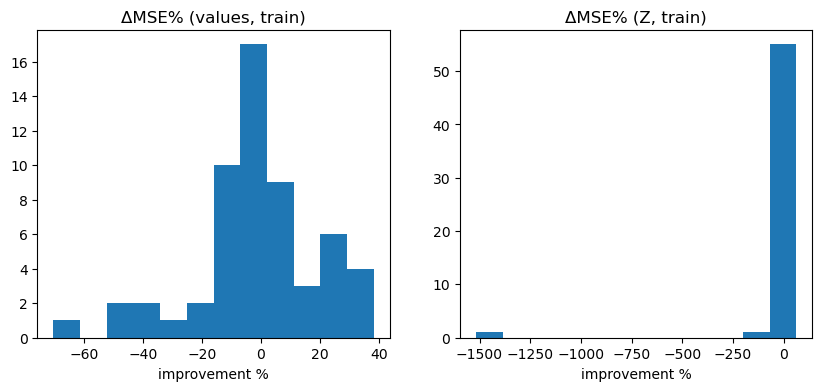


[VAL]  ΔMSE% (values): mean= 10.45  95%CI=(  2.58, 19.41)  sign-test p=0.5034
[VAL]  ΔMSE% (Z):      mean=-133.92  95%CI=(-411.50,  9.50)  sign-test p=1.0000


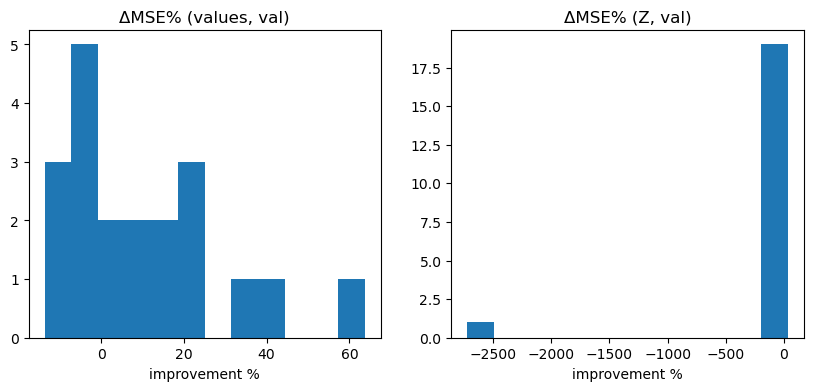


[TEST]  ΔMSE% (values): mean= -3.51  95%CI=(-10.95,  3.08)  sign-test p=0.8238
[TEST]  ΔMSE% (Z):      mean=  0.91  95%CI=(-10.37, 11.83)  sign-test p=0.8238


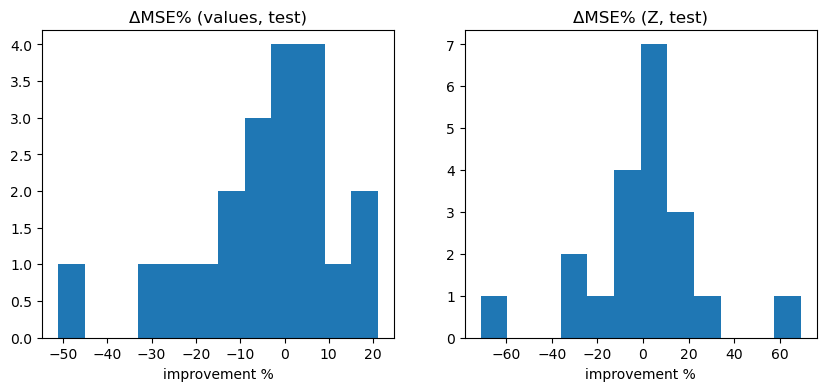

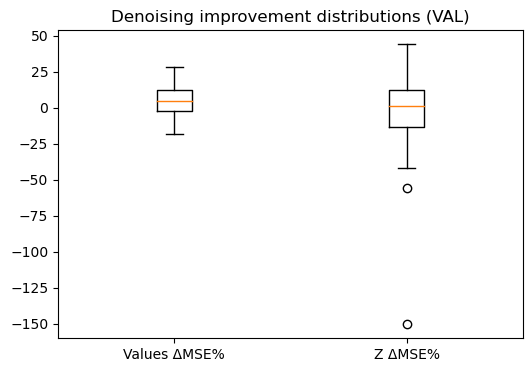

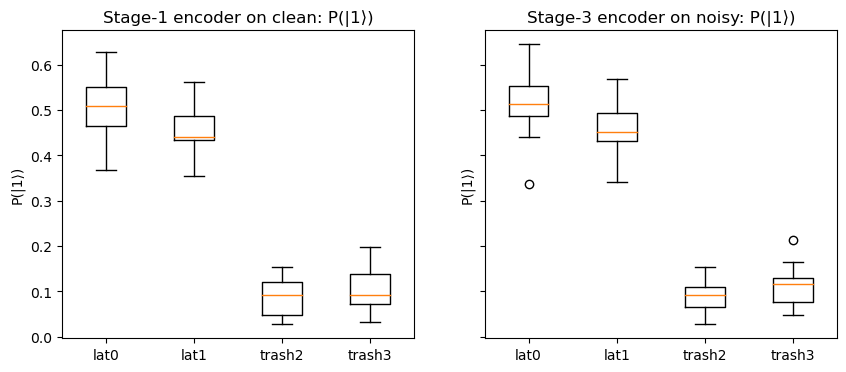

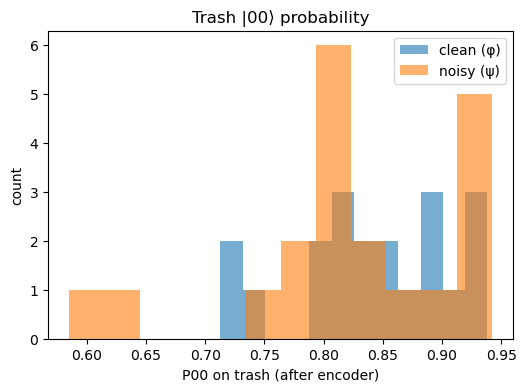

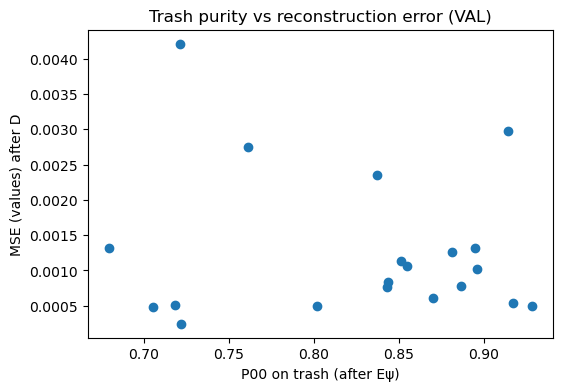

Corr(P00, MSE) on VAL: -0.122


In [120]:
# ---------- Evaluate on train / val / test ----------
splits = [("train", X_train), ("val", X_val), ("test", X_test)]
for name, Xset in splits:
    mZ_n, mZ_d, mV_n, mV_d, dZ, dV = eval_window_sets(psi_stage3, Xset, noise_level=noise_eval)

    # bootstrap CIs for ΔMSE% (values and Z), and paired sign-tests
    mean_dV, lo_dV, hi_dV = bootstrap_ci_mean(dV, B=5000, alpha=0.05)
    mean_dZ, lo_dZ, hi_dZ = bootstrap_ci_mean(dZ, B=5000, alpha=0.05)
    p_val_V = sign_test_pvalue(mV_n - mV_d)   # noisy - deno (positive = improvement)
    p_val_Z = sign_test_pvalue(mZ_n - mZ_d)

    print(f"\n[{name.upper()}]  ΔMSE% (values): mean={mean_dV:6.2f}  95%CI=({lo_dV:6.2f},{hi_dV:6.2f})  sign-test p={p_val_V:.4f}")
    print(f"[{name.upper()}]  ΔMSE% (Z):      mean={mean_dZ:6.2f}  95%CI=({lo_dZ:6.2f},{hi_dZ:6.2f})  sign-test p={p_val_Z:.4f}")

    # histograms
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].hist(dV, bins=12); ax[0].set_title(f"ΔMSE% (values, {name})"); ax[0].set_xlabel("improvement %")
    ax[1].hist(dZ, bins=12); ax[1].set_title(f"ΔMSE% (Z, {name})"); ax[1].set_xlabel("improvement %")
    plt.show()

# ---------- Boxplot summary on VAL ----------
mZ_n, mZ_d, mV_n, mV_d, dZ, dV = eval_window_sets(psi_stage3, X_val, noise_level=noise_eval)
plt.figure(figsize=(6,4))
plt.boxplot([dV, dZ], labels=["Values ΔMSE%", "Z ΔMSE%"])
plt.title("Denoising improvement distributions (VAL)")
plt.show()

# ---------- P(|1>) per wire: Stage-1 on clean vs Stage-3 on noisy ----------
def p1_from_expZ(z): return (1 - np.asarray(z)) * 0.5

# Stage-1 on clean inputs
p1_clean = np.array([p1_from_expZ(encoder_only_expZ_all(phi_stage1, c)) for c in X_val])  # (N,4)

# Stage-3 on noisy inputs
p1_noisy = np.array([p1_from_expZ(encoder_only_expZ_all(psi_stage3, ts_add_noise_window(c, noise_eval))) 
                     for c in X_val])  # (N,4)

labels = ["lat0","lat1","trash2","trash3"]
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax[0].boxplot([p1_clean[:,i] for i in range(4)], labels=labels); ax[0].set_title("Stage-1 encoder on clean: P(|1⟩)")
ax[1].boxplot([p1_noisy[:,i] for i in range(4)], labels=labels); ax[1].set_title("Stage-3 encoder on noisy: P(|1⟩)")
for a in ax: a.set_ylabel("P(|1⟩)")
plt.show()

# ---------- Trash |00⟩ histogram (clean vs noisy via Stage-3 encoder) ----------
P00_clean = []
P00_noisy = []
for c in X_val:
    P = np.array(trash_probs_after_encoder(phi_stage1, c))
    P00_clean.append(P[0])
    P = np.array(trash_probs_after_encoder(psi_stage3, ts_add_noise_window(c, noise_eval)))
    P00_noisy.append(P[0])

plt.figure(figsize=(6,4))
plt.hist(P00_clean, bins=12, alpha=0.6, label="clean (φ)")
plt.hist(P00_noisy, bins=12, alpha=0.6, label="noisy (ψ)")
plt.xlabel("P00 on trash (after encoder)"); plt.ylabel("count"); plt.title("Trash |00⟩ probability")
plt.legend(); plt.show()

# ---------- Trash purity vs reconstruction error (VAL) ----------
errs = []
p00s = []
for c in X_val:
    n = ts_add_noise_window(c, noise_eval)
    # trash |00> after Stage-3 encoder on noisy
    P = np.array(trash_probs_after_encoder(psi_stage3, n))
    p00s.append(P[0])
    # value-domain reconstruction MSE for that window
    z_all_d = np.array(denoiser_qnode_all(psi_stage3, n))
    v_deno  = np.array(Z_to_values(z_all_d))
    errs.append(np.mean((np.asarray(c) - v_deno)**2))

plt.figure(figsize=(6,4))
plt.scatter(p00s, errs)
plt.xlabel("P00 on trash (after Eψ)"); plt.ylabel("MSE (values) after D")
plt.title("Trash purity vs reconstruction error (VAL)")
plt.show()

# Optional: linear correlation
if len(p00s) > 1:
    corr = np.corrcoef(p00s, errs)[0,1]
    print(f"Corr(P00, MSE) on VAL: {corr:+.3f}")


In [117]:
@qml.qnode(dev, interface="autograd", diff_method="backprop")
def z_after_encoder(params, x_win):
    embed_input(x_win)
    encoder_template(params)
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

@qml.qnode(dev, interface="autograd", diff_method="backprop")
def probs_trash_after_encoder(params, x_win):
    embed_input(x_win)
    encoder_template(params)
    return qml.probs(wires=[2,3])  # [P00,P01,P10,P11]

def measure_latent_trash(params, X, noise_level=None):
    P1_lat0=[]; P1_lat1=[]; P1_tr2=[]; P1_tr3=[]; P00=[]
    for c in X:
        x = ts_add_noise_window(c, noise_level) if noise_level is not None else c
        z = np.array(z_after_encoder(params, x))
        p1 = (1.0 - z)/2.0
        P1_lat0.append(p1[0]); P1_lat1.append(p1[1]); P1_tr2.append(p1[2]); P1_tr3.append(p1[3])
        P00.append(np.array(probs_trash_after_encoder(params, x))[0])
    return (np.array(P1_lat0), np.array(P1_lat1),
            np.array(P1_tr2), np.array(P1_tr3),
            np.array(P00))

# Stage-1 clean encoder on clean windows (reference)
ref_lat0, ref_lat1, ref_tr2, ref_tr3, ref_P00 = measure_latent_trash(phi_stage1, X_val, noise_level=None)
# Stage-3 encoder on noisy windows (what we actually run at test time)
noz_lat0, noz_lat1, noz_tr2, noz_tr3, noz_P00 = measure_latent_trash(psi_stage3, X_val, noise_level=noise_eval)

print("Mean P(|1>)  latent0/1   (ref clean):", np.mean(ref_lat0), np.mean(ref_lat1))
print("Mean P(|1>)  trash2/3    (ref clean):", np.mean(ref_tr2), np.mean(ref_tr3))
print("Mean P(|1>)  latent0/1   (noisy, ψ): ", np.mean(noz_lat0), np.mean(noz_lat1))
print("Mean P(|1>)  trash2/3    (noisy, ψ): ", np.mean(noz_tr2), np.mean(noz_tr3))
print("Mean P00(trash) clean vs noisyψ:", np.mean(ref_P00), np.mean(noz_P00))


Mean P(|1>)  latent0/1   (ref clean): 0.5117048316809837 0.4591317613677145
Mean P(|1>)  trash2/3    (ref clean): 0.08874632760310192 0.10366577607533545
Mean P(|1>)  latent0/1   (noisy, ψ):  0.5035878572865793 0.4586679774607688
Mean P(|1>)  trash2/3    (noisy, ψ):  0.10737503435632052 0.11486647791866007
Mean P00(trash) clean vs noisyψ: 0.843192045431268 0.8183492033160219
